In [1]:
# import sys
# import gymnasium as gym
# sys.modules["gym"] = gym
import gym
gym.__version__

'0.21.0'

In [2]:
import gnwrapper

In [3]:
import os
import numpy as np
import torch
print(torch.cuda.is_available())

True


In [4]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback

In [5]:
env_id = "MountainCarContinuous-v0"
NUM_CPU = 32  # Number of processes to use

# Observ Wrapper
```
class MountainCarContinuousObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, num_obs_points: int = 6):
        super().__init__(env)
        self.max_angle = 1
        
        self.low_state = np.append(self.low_state, -self.max_angle)
        self.high_state = np.append(self.high_state, self.max_angle)
        
        self.observation_space = gym.spaces.Box(
            low=self.low_state, high=self.high_state, dtype=np.float32
        )
        
    def observation(self, obs):
        return np.append(obs, np.cos(3 * obs[0]))
```

In [6]:
from MountainCar_utils import MountainCarContinuousObsWrapper
def wrapper(env):
    env = MountainCarContinuousObsWrapper(env) 
    env = gnwrapper.Animation(env)
    return env

# Training 'expert' and 'noob' policy
Skip this if you have trained policies

In [8]:
# Parallel custom obs environments
train_env_f = make_vec_env(env_id, 
                           n_envs=NUM_CPU,
                           wrapper_class=MountainCarContinuousObsWrapper)
train_env_f.observation_space

/home/vlad1slav/Diploma/rl-venv/lib/python3.10/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Box([-1.2  -0.07 -1.  ], [0.6  0.07 1.  ], (3,), float32)

In [9]:
eval_callback = EvalCallback(train_env_f, 
                             best_model_save_path="./logs/best_model/expert",
                             log_path="./logs/results",
                             eval_freq=500,
                             deterministic=True, render=False)
model = PPO("MlpPolicy", 
            train_env_f,
            verbose=1, 
            seed=0,
            batch_size=512,
            # ent_coef=0.00429,
            learning_rate=7.77e-05,
            n_epochs=10,
            n_steps=8*NUM_CPU,
            gae_lambda=0.9,
            gamma=0.9999,
            # clip_range=0.1,
            max_grad_norm=5,
            # vf_coef=0.19,
            use_sde=True,
            # policy_kwargs=dict(log_std_init=-3.29, ortho_init=False),
            tensorboard_log="./logs/ppo_MountainCar_tensorboard_expert/")

model.learn(total_timesteps=1_000_000, callback=eval_callback, progress_bar=True)
model.save("./logs/ppo_MountainCar_expert")

del model # remove to demonstrate saving and loading

Using cuda device
Logging to ./logs/ppo_MountainCar_tensorboard_expert/PPO_1


Output()

-----------------------------
| time/              |      |
|    fps             | 9386 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 8192 |
-----------------------------


Eval num_timesteps=16000, episode_reward=-1.06 +/- 0.11
   1% ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14,272/1,000,000  [ 0:00:03 < 0:02:01 , 8,169 it/s ]

Episode length: 999.00 +/- 0.00
   1% ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14,272/1,000,000  [ 0:00:03 < 0:02:01 , 8,169 it/s ]

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 999       |
|    mean_reward          | -1.06     |
| time/                   |           |
|    total_timesteps      | 16000     |
| train/                  |           |
|    approx_kl            | 0.0422756 |
|    clip_fraction        | 0.135     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.78     |
|    explained_variance   | 0.0307    |
|    learning_rate        | 7.77e-05  |
|    loss                 | 0.171     |
|    n_updates            | 10        |
|    policy_gradient_loss | 0.05      |
|    std                  | 0.988     |
|    value_loss           | 0.262     |
---------------------------------------


New best mean reward!
   1% ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14,272/1,000,000  [ 0:00:03 < 0:02:01 , 8,169 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 294      |
|    ep_rew_mean     | 71.5     |
| time/              |          |
|    fps             | 4491     |
|    iterations      | 2        |
|    time_elapsed    | 3        |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 294         |
|    ep_rew_mean          | 71.5        |
| time/                   |             |
|    fps                  | 5051        |
|    iterations           | 3           |
|    time_elapsed         | 4           |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.032701466 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | 0.0245      |
|    learning_rate        | 7.

Eval num_timesteps=32000, episode_reward=-10.27 +/- 1.58
   3% ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30,624/1,000,000  [ 0:00:07 < 0:03:01 , 5,362 it/s ]

Episode length: 999.00 +/- 0.00
   3% ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30,624/1,000,000  [ 0:00:07 < 0:03:01 , 5,362 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 999         |
|    mean_reward          | -10.3       |
| time/                   |             |
|    total_timesteps      | 32000       |
| train/                  |             |
|    approx_kl            | 0.015324648 |
|    clip_fraction        | 0.0649      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.24       |
|    explained_variance   | 0.509       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 0.12        |
|    n_updates            | 30          |
|    policy_gradient_loss | 0.0267      |
|    std                  | 0.975       |
|    value_loss           | 0.198       |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 294      |
|    ep_rew_mean     | 71.5     |
| time/              |          |
|    fps             | 4220     

Eval num_timesteps=48000, episode_reward=-44.64 +/- 1.92
   5% ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46,560/1,000,000  [ 0:00:11 < 0:03:22 , 4,729 it/s ]

Episode length: 999.00 +/- 0.00
   5% ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46,560/1,000,000  [ 0:00:11 < 0:03:22 , 4,729 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 999         |
|    mean_reward          | -44.6       |
| time/                   |             |
|    total_timesteps      | 48000       |
| train/                  |             |
|    approx_kl            | 0.026048336 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.51       |
|    explained_variance   | 0.0866      |
|    learning_rate        | 7.77e-05    |
|    loss                 | 0.113       |
|    n_updates            | 50          |
|    policy_gradient_loss | 0.00101     |
|    std                  | 0.961       |
|    value_loss           | 6.77        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 341      |
|    ep_rew_mean     | 71.6     |
| time/              |          |
|    fps             | 4167     

Eval num_timesteps=64000, episode_reward=-60.98 +/- 1.34
   6% ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62,656/1,000,000  [ 0:00:15 < 0:03:27 , 4,532 it/s ]

Episode length: 999.00 +/- 0.00
   6% ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62,656/1,000,000  [ 0:00:15 < 0:03:27 , 4,532 it/s ]

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 999           |
|    mean_reward          | -61           |
| time/                   |               |
|    total_timesteps      | 64000         |
| train/                  |               |
|    approx_kl            | 0.00048430433 |
|    clip_fraction        | 0.00171       |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.48         |
|    explained_variance   | 0.105         |
|    learning_rate        | 7.77e-05      |
|    loss                 | 2.65          |
|    n_updates            | 70            |
|    policy_gradient_loss | -0.000249     |
|    std                  | 0.952         |
|    value_loss           | 13.4          |
-------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 307      |
|    ep_rew_mean     | 75.1     |
| time/              |      

Eval num_timesteps=80000, episode_reward=-71.83 +/- 5.64
   8% ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79,168/1,000,000  [ 0:00:19 < 0:03:28 , 4,447 it/s ]

Episode length: 999.00 +/- 0.00
   8% ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79,168/1,000,000  [ 0:00:19 < 0:03:28 , 4,447 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 999        |
|    mean_reward          | -71.8      |
| time/                   |            |
|    total_timesteps      | 80000      |
| train/                  |            |
|    approx_kl            | 0.00514522 |
|    clip_fraction        | 0.0494     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.74      |
|    explained_variance   | 0.234      |
|    learning_rate        | 7.77e-05   |
|    loss                 | 12.3       |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.00487   |
|    std                  | 0.946      |
|    value_loss           | 13.3       |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 295      |
|    ep_rew_mean     | 77.7     |
| time/              |          |
|    fps             | 4147     |
|    iterations  

Eval num_timesteps=96000, episode_reward=-73.44 +/- 4.65
   9% ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94,240/1,000,000  [ 0:00:23 < 0:03:29 , 4,338 it/s ]

Episode length: 999.00 +/- 0.00
   9% ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94,240/1,000,000  [ 0:00:23 < 0:03:29 , 4,338 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 999          |
|    mean_reward          | -73.4        |
| time/                   |              |
|    total_timesteps      | 96000        |
| train/                  |              |
|    approx_kl            | 0.0012335032 |
|    clip_fraction        | 0.00272      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.58        |
|    explained_variance   | 0.216        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 31.4         |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00233     |
|    std                  | 0.94         |
|    value_loss           | 50.3         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 245      |
|    ep_rew_mean     | 80.8     |
| time/              |          |
|    fps     

Eval num_timesteps=112000, episode_reward=-51.65 +/- 50.53
  11% ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111,392/1,000,000  [ 0:00:27 < 0:03:25 , 4,340 it/s ]

Episode length: 961.20 +/- 75.60
  11% ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111,392/1,000,000  [ 0:00:27 < 0:03:25 , 4,340 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 961        |
|    mean_reward          | -51.7      |
| time/                   |            |
|    total_timesteps      | 112000     |
| train/                  |            |
|    approx_kl            | 0.03204587 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.76      |
|    explained_variance   | 0.381      |
|    learning_rate        | 7.77e-05   |
|    loss                 | 5.12       |
|    n_updates            | 130        |
|    policy_gradient_loss | -0.00359   |
|    std                  | 0.925      |
|    value_loss           | 24.8       |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 260      |
|    ep_rew_mean     | 79.1     |
| time/              |          |
|    fps             | 4146     |
|    iterations  

Eval num_timesteps=128000, episode_reward=-67.14 +/- 60.21
  13% ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126,976/1,000,000  [ 0:00:31 < 0:03:24 , 4,297 it/s ]

Episode length: 925.80 +/- 146.40
  13% ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126,976/1,000,000  [ 0:00:31 < 0:03:24 , 4,297 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 926         |
|    mean_reward          | -67.1       |
| time/                   |             |
|    total_timesteps      | 128000      |
| train/                  |             |
|    approx_kl            | 0.019567013 |
|    clip_fraction        | 0.0891      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | 0.516       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 6.05        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00703    |
|    std                  | 0.915       |
|    value_loss           | 18.6        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 282      |
|    ep_rew_mean     | 77       |
| time/              |          |
|    fps             | 4145     

Eval num_timesteps=144000, episode_reward=-30.73 +/- 72.59
  14% ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143,680/1,000,000  [ 0:00:35 < 0:03:20 , 4,299 it/s ]

Episode length: 834.60 +/- 201.38
  14% ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143,680/1,000,000  [ 0:00:35 < 0:03:20 , 4,299 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 835          |
|    mean_reward          | -30.7        |
| time/                   |              |
|    total_timesteps      | 144000       |
| train/                  |              |
|    approx_kl            | 0.0031074793 |
|    clip_fraction        | 0.0145       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.67        |
|    explained_variance   | 0.592        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 3.2          |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.0049      |
|    std                  | 0.901        |
|    value_loss           | 6.29         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 317      |
|    ep_rew_mean     | 73.2     |
| time/              |          |
|    fps     

Eval num_timesteps=160000, episode_reward=30.44 +/- 57.41
  16% ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158,528/1,000,000  [ 0:00:39 < 0:03:20 , 4,216 it/s ]

Episode length: 634.40 +/- 195.22
  16% ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158,528/1,000,000  [ 0:00:39 < 0:03:20 , 4,216 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 634          |
|    mean_reward          | 30.4         |
| time/                   |              |
|    total_timesteps      | 160000       |
| train/                  |              |
|    approx_kl            | 0.0073532127 |
|    clip_fraction        | 0.0495       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.67        |
|    explained_variance   | 0.547        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 11.4         |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00794     |
|    std                  | 0.889        |
|    value_loss           | 22.9         |
------------------------------------------


New best mean reward!
  16% ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158,528/1,000,000  [ 0:00:39 < 0:03:20 , 4,216 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 364      |
|    ep_rew_mean     | 67.7     |
| time/              |          |
|    fps             | 4148     |
|    iterations      | 20       |
|    time_elapsed    | 39       |
|    total_timesteps | 163840   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 376          |
|    ep_rew_mean          | 64           |
| time/                   |              |
|    fps                  | 4225         |
|    iterations           | 21           |
|    time_elapsed         | 40           |
|    total_timesteps      | 172032       |
| train/                  |              |
|    approx_kl            | 0.0038089647 |
|    clip_fraction        | 0.0083       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.67        |
|    explained_variance   | 0.522        |
|    learning_r

Eval num_timesteps=176000, episode_reward=32.20 +/- 68.06
  18% ━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175,680/1,000,000  [ 0:00:43 < 0:03:14 , 4,259 it/s ]

Episode length: 556.80 +/- 289.97
  18% ━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175,680/1,000,000  [ 0:00:43 < 0:03:14 , 4,259 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 557         |
|    mean_reward          | 32.2        |
| time/                   |             |
|    total_timesteps      | 176000      |
| train/                  |             |
|    approx_kl            | 0.005749942 |
|    clip_fraction        | 0.0626      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.6        |
|    explained_variance   | 0.488       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 18.8        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00432    |
|    std                  | 0.878       |
|    value_loss           | 39.9        |
-----------------------------------------


New best mean reward!
  18% ━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175,680/1,000,000  [ 0:00:43 < 0:03:14 , 4,259 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 410      |
|    ep_rew_mean     | 58.1     |
| time/              |          |
|    fps             | 4149     |
|    iterations      | 22       |
|    time_elapsed    | 43       |
|    total_timesteps | 180224   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 469          |
|    ep_rew_mean          | 44.6         |
| time/                   |              |
|    fps                  | 4217         |
|    iterations           | 23           |
|    time_elapsed         | 44           |
|    total_timesteps      | 188416       |
| train/                  |              |
|    approx_kl            | 0.0024291193 |
|    clip_fraction        | 0.0385       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.61        |
|    explained_variance   | 0.539        |
|    learning_r

Eval num_timesteps=192000, episode_reward=70.46 +/- 6.19
  19% ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190,656/1,000,000  [ 0:00:46 < 0:03:11 , 4,238 it/s ]

Episode length: 365.20 +/- 70.44
  19% ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190,656/1,000,000  [ 0:00:46 < 0:03:11 , 4,238 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 365        |
|    mean_reward          | 70.5       |
| time/                   |            |
|    total_timesteps      | 192000     |
| train/                  |            |
|    approx_kl            | 0.00683448 |
|    clip_fraction        | 0.0505     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.63      |
|    explained_variance   | 0.615      |
|    learning_rate        | 7.77e-05   |
|    loss                 | 9.41       |
|    n_updates            | 230        |
|    policy_gradient_loss | -0.00174   |
|    std                  | 0.868      |
|    value_loss           | 42.2       |
----------------------------------------


New best mean reward!
  19% ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190,656/1,000,000  [ 0:00:46 < 0:03:11 , 4,238 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 504      |
|    ep_rew_mean     | 39.2     |
| time/              |          |
|    fps             | 4221     |
|    iterations      | 24       |
|    time_elapsed    | 46       |
|    total_timesteps | 196608   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 521          |
|    ep_rew_mean          | 37.7         |
| time/                   |              |
|    fps                  | 4280         |
|    iterations           | 25           |
|    time_elapsed         | 47           |
|    total_timesteps      | 204800       |
| train/                  |              |
|    approx_kl            | 0.0031682556 |
|    clip_fraction        | 0.01         |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.56        |
|    explained_variance   | 0.598        |
|    learning_r

Eval num_timesteps=208000, episode_reward=28.73 +/- 65.01
  21% ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206,944/1,000,000  [ 0:00:50 < 0:03:03 , 4,349 it/s ]

Episode length: 577.80 +/- 235.25
  21% ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206,944/1,000,000  [ 0:00:50 < 0:03:03 , 4,349 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 578          |
|    mean_reward          | 28.7         |
| time/                   |              |
|    total_timesteps      | 208000       |
| train/                  |              |
|    approx_kl            | 0.0034431769 |
|    clip_fraction        | 0.00986      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.55        |
|    explained_variance   | 0.606        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 17.3         |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.00495     |
|    std                  | 0.859        |
|    value_loss           | 43.5         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 537      |
|    ep_rew_mean     | 36.2     |
| time/              |          |
|    fps     

Eval num_timesteps=224000, episode_reward=64.24 +/- 20.73
  22% ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222,688/1,000,000  [ 0:00:53 < 0:02:59 , 4,354 it/s ]

Episode length: 422.20 +/- 224.93
  22% ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222,688/1,000,000  [ 0:00:53 < 0:02:59 , 4,354 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 422        |
|    mean_reward          | 64.2       |
| time/                   |            |
|    total_timesteps      | 224000     |
| train/                  |            |
|    approx_kl            | 0.00438564 |
|    clip_fraction        | 0.03       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.58      |
|    explained_variance   | 0.624      |
|    learning_rate        | 7.77e-05   |
|    loss                 | 22.4       |
|    n_updates            | 270        |
|    policy_gradient_loss | -0.00235   |
|    std                  | 0.851      |
|    value_loss           | 44.1       |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 591      |
|    ep_rew_mean     | 18.1     |
| time/              |          |
|    fps             | 4223     |
|    iterations  

Eval num_timesteps=240000, episode_reward=-64.25 +/- 71.30
  24% ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239,392/1,000,000  [ 0:00:57 < 0:02:54 , 4,391 it/s ]

Episode length: 853.00 +/- 292.00
  24% ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239,392/1,000,000  [ 0:00:57 < 0:02:54 , 4,391 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 853         |
|    mean_reward          | -64.3       |
| time/                   |             |
|    total_timesteps      | 240000      |
| train/                  |             |
|    approx_kl            | 0.009914284 |
|    clip_fraction        | 0.0902      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0.642       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 21.8        |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00616    |
|    std                  | 0.85        |
|    value_loss           | 45.1        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 575      |
|    ep_rew_mean     | 20.3     |
| time/              |          |
|    fps             | 4220     

Eval num_timesteps=256000, episode_reward=42.18 +/- 71.33
  25% ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254,368/1,000,000  [ 0:01:01 < 0:02:51 , 4,381 it/s ]

Episode length: 413.60 +/- 302.45
  25% ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254,368/1,000,000  [ 0:01:01 < 0:02:51 , 4,381 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 414         |
|    mean_reward          | 42.2        |
| time/                   |             |
|    total_timesteps      | 256000      |
| train/                  |             |
|    approx_kl            | 0.008853349 |
|    clip_fraction        | 0.0343      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.5        |
|    explained_variance   | 0.713       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 34.2        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00118    |
|    std                  | 0.85        |
|    value_loss           | 46.7        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 558      |
|    ep_rew_mean     | 24.4     |
| time/              |          |
|    fps             | 4218     

Eval num_timesteps=272000, episode_reward=10.11 +/- 89.88
  27% ━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271,264/1,000,000  [ 0:01:05 < 0:02:47 , 4,385 it/s ]

Episode length: 516.40 +/- 396.15
  27% ━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271,264/1,000,000  [ 0:01:05 < 0:02:47 , 4,385 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 516         |
|    mean_reward          | 10.1        |
| time/                   |             |
|    total_timesteps      | 272000      |
| train/                  |             |
|    approx_kl            | 0.006029187 |
|    clip_fraction        | 0.0503      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.51       |
|    explained_variance   | 0.698       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 21.7        |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.00306    |
|    std                  | 0.837       |
|    value_loss           | 38          |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 562      |
|    ep_rew_mean     | 17.5     |
| time/              |          |
|    fps             | 4215     

Eval num_timesteps=288000, episode_reward=9.84 +/- 89.62
  29% ━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287,712/1,000,000  [ 0:01:09 < 0:02:41 , 4,428 it/s ]

Episode length: 519.80 +/- 392.06
  29% ━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287,712/1,000,000  [ 0:01:09 < 0:02:41 , 4,428 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 520         |
|    mean_reward          | 9.84        |
| time/                   |             |
|    total_timesteps      | 288000      |
| train/                  |             |
|    approx_kl            | 0.008548347 |
|    clip_fraction        | 0.0348      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.43       |
|    explained_variance   | 0.721       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 29.3        |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00353    |
|    std                  | 0.836       |
|    value_loss           | 56.7        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 524      |
|    ep_rew_mean     | 22.2     |
| time/              |          |
|    fps             | 4213     

Eval num_timesteps=304000, episode_reward=43.95 +/- 72.09
  30% ━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302,528/1,000,000  [ 0:01:13 < 0:02:39 , 4,391 it/s ]

Episode length: 385.40 +/- 311.84
  30% ━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302,528/1,000,000  [ 0:01:13 < 0:02:39 , 4,391 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 385          |
|    mean_reward          | 43.9         |
| time/                   |              |
|    total_timesteps      | 304000       |
| train/                  |              |
|    approx_kl            | 0.0022016577 |
|    clip_fraction        | 0.0164       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.44        |
|    explained_variance   | 0.704        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 45.6         |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.00412     |
|    std                  | 0.828        |
|    value_loss           | 97.8         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 453      |
|    ep_rew_mean     | 34.8     |
| time/              |          |
|    fps     

Eval num_timesteps=320000, episode_reward=80.61 +/- 10.01
  32% ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319,552/1,000,000  [ 0:01:16 < 0:02:38 , 4,314 it/s ]

Episode length: 220.20 +/- 116.01
  32% ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319,552/1,000,000  [ 0:01:16 < 0:02:38 , 4,314 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 220          |
|    mean_reward          | 80.6         |
| time/                   |              |
|    total_timesteps      | 320000       |
| train/                  |              |
|    approx_kl            | 0.0024031766 |
|    clip_fraction        | 0.0265       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.43        |
|    explained_variance   | 0.731        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 32.6         |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.00258     |
|    std                  | 0.822        |
|    value_loss           | 67.1         |
------------------------------------------


New best mean reward!
  32% ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319,552/1,000,000  [ 0:01:16 < 0:02:38 , 4,314 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 433      |
|    ep_rew_mean     | 39.6     |
| time/              |          |
|    fps             | 4258     |
|    iterations      | 40       |
|    time_elapsed    | 76       |
|    total_timesteps | 327680   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 389         |
|    ep_rew_mean          | 51          |
| time/                   |             |
|    fps                  | 4294        |
|    iterations           | 41          |
|    time_elapsed         | 78          |
|    total_timesteps      | 335872      |
| train/                  |             |
|    approx_kl            | 0.006176679 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.45       |
|    explained_variance   | 0.635       |
|    learning_rate        | 7.

Eval num_timesteps=336000, episode_reward=72.31 +/- 12.82
  34% ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335,872/1,000,000  [ 0:01:19 < 0:02:31 , 4,413 it/s ]

Episode length: 313.60 +/- 142.71
  34% ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335,872/1,000,000  [ 0:01:19 < 0:02:31 , 4,413 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 314        |
|    mean_reward          | 72.3       |
| time/                   |            |
|    total_timesteps      | 336000     |
| train/                  |            |
|    approx_kl            | 0.00117026 |
|    clip_fraction        | 0.00997    |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.44      |
|    explained_variance   | 0.687      |
|    learning_rate        | 7.77e-05   |
|    loss                 | 57.2       |
|    n_updates            | 410        |
|    policy_gradient_loss | -0.00232   |
|    std                  | 0.816      |
|    value_loss           | 112        |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 358      |
|    ep_rew_mean     | 56.3     |
| time/              |          |
|    fps             | 4287     |
|    iterations  

Eval num_timesteps=352000, episode_reward=77.96 +/- 7.03
  35% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351,136/1,000,000  [ 0:01:22 < 0:02:23 , 4,561 it/s ]

Episode length: 250.60 +/- 78.31
  35% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351,136/1,000,000  [ 0:01:22 < 0:02:23 , 4,561 it/s ]

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 251           |
|    mean_reward          | 78            |
| time/                   |               |
|    total_timesteps      | 352000        |
| train/                  |               |
|    approx_kl            | 0.00078389945 |
|    clip_fraction        | 0.00992       |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.44         |
|    explained_variance   | 0.696         |
|    learning_rate        | 7.77e-05      |
|    loss                 | 32.3          |
|    n_updates            | 420           |
|    policy_gradient_loss | -0.00339      |
|    std                  | 0.815         |
|    value_loss           | 82.5          |
-------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 382      |
|    ep_rew_mean     | 53       |
| time/              |      

Eval num_timesteps=368000, episode_reward=10.43 +/- 90.15
  37% ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367,936/1,000,000  [ 0:01:25 < 0:02:16 , 4,672 it/s ]

Episode length: 507.60 +/- 403.43
  37% ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367,936/1,000,000  [ 0:01:25 < 0:02:16 , 4,672 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 508          |
|    mean_reward          | 10.4         |
| time/                   |              |
|    total_timesteps      | 368000       |
| train/                  |              |
|    approx_kl            | 0.0074087735 |
|    clip_fraction        | 0.0341       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.44        |
|    explained_variance   | 0.732        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 49.9         |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.00818     |
|    std                  | 0.807        |
|    value_loss           | 119          |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 290      |
|    ep_rew_mean     | 72.3     |
| time/              |          |
|    fps     

Eval num_timesteps=384000, episode_reward=28.92 +/- 69.50
  38% ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383,040/1,000,000  [ 0:01:29 < 0:02:13 , 4,667 it/s ]

Episode length: 536.20 +/- 354.02
  38% ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383,040/1,000,000  [ 0:01:29 < 0:02:13 , 4,667 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 536          |
|    mean_reward          | 28.9         |
| time/                   |              |
|    total_timesteps      | 384000       |
| train/                  |              |
|    approx_kl            | 0.0051248316 |
|    clip_fraction        | 0.018        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.41        |
|    explained_variance   | 0.723        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 38.8         |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.00358     |
|    std                  | 0.793        |
|    value_loss           | 96.7         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 306      |
|    ep_rew_mean     | 65.1     |
| time/              |          |
|    fps     

Eval num_timesteps=400000, episode_reward=47.86 +/- 73.97
  40% ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399,008/1,000,000  [ 0:01:33 < 0:02:10 , 4,640 it/s ]

Episode length: 334.40 +/- 335.22
  40% ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399,008/1,000,000  [ 0:01:33 < 0:02:10 , 4,640 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 334         |
|    mean_reward          | 47.9        |
| time/                   |             |
|    total_timesteps      | 400000      |
| train/                  |             |
|    approx_kl            | 0.008448731 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | 0.735       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 53.2        |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.00527    |
|    std                  | 0.785       |
|    value_loss           | 82.8        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 339      |
|    ep_rew_mean     | 55.3     |
| time/              |          |
|    fps             | 4270     

Eval num_timesteps=416000, episode_reward=45.87 +/- 73.01
  42% ━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415,328/1,000,000  [ 0:01:37 < 0:02:07 , 4,628 it/s ]

Episode length: 357.80 +/- 324.57
  42% ━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415,328/1,000,000  [ 0:01:37 < 0:02:07 , 4,628 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 358          |
|    mean_reward          | 45.9         |
| time/                   |              |
|    total_timesteps      | 416000       |
| train/                  |              |
|    approx_kl            | 0.0047094543 |
|    clip_fraction        | 0.0279       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.27        |
|    explained_variance   | 0.75         |
|    learning_rate        | 7.77e-05     |
|    loss                 | 39.9         |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.00347     |
|    std                  | 0.778        |
|    value_loss           | 87.3         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 361      |
|    ep_rew_mean     | 49.7     |
| time/              |          |
|    fps     

Eval num_timesteps=432000, episode_reward=87.77 +/- 2.62
  43% ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431,872/1,000,000  [ 0:01:40 < 0:02:03 , 4,641 it/s ]

Episode length: 132.20 +/- 30.31
  43% ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431,872/1,000,000  [ 0:01:40 < 0:02:03 , 4,641 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 132          |
|    mean_reward          | 87.8         |
| time/                   |              |
|    total_timesteps      | 432000       |
| train/                  |              |
|    approx_kl            | 0.0025148795 |
|    clip_fraction        | 0.0236       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.29        |
|    explained_variance   | 0.761        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 39.6         |
|    n_updates            | 520          |
|    policy_gradient_loss | -0.00849     |
|    std                  | 0.777        |
|    value_loss           | 86.7         |
------------------------------------------


New best mean reward!
  43% ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431,872/1,000,000  [ 0:01:40 < 0:02:03 , 4,641 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 324      |
|    ep_rew_mean     | 56.2     |
| time/              |          |
|    fps             | 4315     |
|    iterations      | 53       |
|    time_elapsed    | 100      |
|    total_timesteps | 434176   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 285         |
|    ep_rew_mean          | 65.1        |
| time/                   |             |
|    fps                  | 4344        |
|    iterations           | 54          |
|    time_elapsed         | 101         |
|    total_timesteps      | 442368      |
| train/                  |             |
|    approx_kl            | 0.006932225 |
|    clip_fraction        | 0.0332      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.25       |
|    explained_variance   | 0.743       |
|    learning_rate        | 7.

Eval num_timesteps=448000, episode_reward=84.53 +/- 5.14
  45% ━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446,848/1,000,000  [ 0:01:43 < 0:01:54 , 4,868 it/s ]

Episode length: 167.40 +/- 57.97
  45% ━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446,848/1,000,000  [ 0:01:43 < 0:01:54 , 4,868 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 167          |
|    mean_reward          | 84.5         |
| time/                   |              |
|    total_timesteps      | 448000       |
| train/                  |              |
|    approx_kl            | 0.0018467143 |
|    clip_fraction        | 0.0151       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.34        |
|    explained_variance   | 0.753        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 64.8         |
|    n_updates            | 540          |
|    policy_gradient_loss | -0.00241     |
|    std                  | 0.774        |
|    value_loss           | 109          |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 259      |
|    ep_rew_mean     | 70.8     |
| time/              |          |
|    fps     

Eval num_timesteps=464000, episode_reward=84.99 +/- 4.04
  46% ━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463,840/1,000,000  [ 0:01:45 < 0:01:51 , 4,843 it/s ]

Episode length: 162.20 +/- 43.74
  46% ━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463,840/1,000,000  [ 0:01:45 < 0:01:51 , 4,843 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 162          |
|    mean_reward          | 85           |
| time/                   |              |
|    total_timesteps      | 464000       |
| train/                  |              |
|    approx_kl            | 0.0030821778 |
|    clip_fraction        | 0.0304       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.26        |
|    explained_variance   | 0.756        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 47.9         |
|    n_updates            | 560          |
|    policy_gradient_loss | -0.0011      |
|    std                  | 0.774        |
|    value_loss           | 115          |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 217      |
|    ep_rew_mean     | 80.1     |
| time/              |          |
|    fps     

Eval num_timesteps=480000, episode_reward=85.98 +/- 4.43
  48% ━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478,976/1,000,000  [ 0:01:48 < 0:01:46 , 4,958 it/s ]

Episode length: 152.40 +/- 52.94
  48% ━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478,976/1,000,000  [ 0:01:48 < 0:01:46 , 4,958 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 152         |
|    mean_reward          | 86          |
| time/                   |             |
|    total_timesteps      | 480000      |
| train/                  |             |
|    approx_kl            | 0.012410551 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.22       |
|    explained_variance   | 0.775       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 55.5        |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.0127     |
|    std                  | 0.775       |
|    value_loss           | 110         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 198      |
|    ep_rew_mean     | 81.7     |
| time/              |          |
|    fps             | 4433     

Eval num_timesteps=496000, episode_reward=73.83 +/- 19.03
  50% ━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495,744/1,000,000  [ 0:01:52 < 0:01:42 , 4,946 it/s ]

Episode length: 278.60 +/- 200.95
  50% ━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495,744/1,000,000  [ 0:01:52 < 0:01:42 , 4,946 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 279          |
|    mean_reward          | 73.8         |
| time/                   |              |
|    total_timesteps      | 496000       |
| train/                  |              |
|    approx_kl            | 0.0028336637 |
|    clip_fraction        | 0.0191       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.32        |
|    explained_variance   | 0.758        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 62.5         |
|    n_updates            | 600          |
|    policy_gradient_loss | -0.00236     |
|    std                  | 0.771        |
|    value_loss           | 128          |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 172      |
|    ep_rew_mean     | 84.1     |
| time/              |          |
|    fps     

Eval num_timesteps=512000, episode_reward=82.30 +/- 10.20
  51% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 510,528/1,000,000  [ 0:01:55 < 0:01:42 , 4,812 it/s ]

Episode length: 187.40 +/- 109.43
  51% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 510,528/1,000,000  [ 0:01:55 < 0:01:42 , 4,812 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 187          |
|    mean_reward          | 82.3         |
| time/                   |              |
|    total_timesteps      | 512000       |
| train/                  |              |
|    approx_kl            | 0.0060603535 |
|    clip_fraction        | 0.0565       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.28        |
|    explained_variance   | 0.755        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 61.3         |
|    n_updates            | 620          |
|    policy_gradient_loss | -0.00681     |
|    std                  | 0.767        |
|    value_loss           | 126          |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 169      |
|    ep_rew_mean     | 84.3     |
| time/              |          |
|    fps     

Eval num_timesteps=528000, episode_reward=87.56 +/- 2.58
  53% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━ 527,072/1,000,000  [ 0:01:57 < 0:01:34 , 5,067 it/s ]

Episode length: 132.60 +/- 30.31
  53% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━ 527,072/1,000,000  [ 0:01:57 < 0:01:34 , 5,067 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 133          |
|    mean_reward          | 87.6         |
| time/                   |              |
|    total_timesteps      | 528000       |
| train/                  |              |
|    approx_kl            | 0.0046265074 |
|    clip_fraction        | 0.0177       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.34        |
|    explained_variance   | 0.759        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 65           |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.00349     |
|    std                  | 0.756        |
|    value_loss           | 128          |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 153      |
|    ep_rew_mean     | 85.7     |
| time/              |          |
|    fps     

Eval num_timesteps=544000, episode_reward=84.47 +/- 6.75
  54% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━ 542,176/1,000,000  [ 0:02:00 < 0:01:26 , 5,338 it/s ]

Episode length: 164.60 +/- 74.06
  54% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━ 542,176/1,000,000  [ 0:02:00 < 0:01:26 , 5,338 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 165        |
|    mean_reward          | 84.5       |
| time/                   |            |
|    total_timesteps      | 544000     |
| train/                  |            |
|    approx_kl            | 0.00651427 |
|    clip_fraction        | 0.0633     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.35      |
|    explained_variance   | 0.764      |
|    learning_rate        | 7.77e-05   |
|    loss                 | 54.2       |
|    n_updates            | 660        |
|    policy_gradient_loss | -0.00685   |
|    std                  | 0.75       |
|    value_loss           | 130        |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 145      |
|    ep_rew_mean     | 86.3     |
| time/              |          |
|    fps             | 4540     |
|    iterations  

Eval num_timesteps=560000, episode_reward=84.14 +/- 6.37
  56% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 559,200/1,000,000  [ 0:02:03 < 0:01:21 , 5,469 it/s ]

Episode length: 168.00 +/- 70.46
  56% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 559,200/1,000,000  [ 0:02:03 < 0:01:21 , 5,469 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 168         |
|    mean_reward          | 84.1        |
| time/                   |             |
|    total_timesteps      | 560000      |
| train/                  |             |
|    approx_kl            | 0.002408532 |
|    clip_fraction        | 0.00934     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.35       |
|    explained_variance   | 0.767       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 68.2        |
|    n_updates            | 680         |
|    policy_gradient_loss | -0.00215    |
|    std                  | 0.75        |
|    value_loss           | 126         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 135      |
|    ep_rew_mean     | 87.2     |
| time/              |          |
|    fps             | 4569     

Eval num_timesteps=576000, episode_reward=88.21 +/- 2.86
  57% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 574,240/1,000,000  [ 0:02:06 < 0:01:18 , 5,525 it/s ]

Episode length: 123.80 +/- 32.20
  57% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 574,240/1,000,000  [ 0:02:06 < 0:01:18 , 5,525 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 124          |
|    mean_reward          | 88.2         |
| time/                   |              |
|    total_timesteps      | 576000       |
| train/                  |              |
|    approx_kl            | 0.0036381723 |
|    clip_fraction        | 0.0384       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.32        |
|    explained_variance   | 0.752        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 50.9         |
|    n_updates            | 700          |
|    policy_gradient_loss | -0.00673     |
|    std                  | 0.74         |
|    value_loss           | 110          |
------------------------------------------


New best mean reward!
  57% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 574,240/1,000,000  [ 0:02:06 < 0:01:18 , 5,525 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 150      |
|    ep_rew_mean     | 85.8     |
| time/              |          |
|    fps             | 4600     |
|    iterations      | 71       |
|    time_elapsed    | 126      |
|    total_timesteps | 581632   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 144          |
|    ep_rew_mean          | 86.3         |
| time/                   |              |
|    fps                  | 4620         |
|    iterations           | 72           |
|    time_elapsed         | 127          |
|    total_timesteps      | 589824       |
| train/                  |              |
|    approx_kl            | 0.0029659416 |
|    clip_fraction        | 0.023        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.33        |
|    explained_variance   | 0.738        |
|    learning_r

Eval num_timesteps=592000, episode_reward=85.41 +/- 3.71
  59% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━ 590,944/1,000,000  [ 0:02:08 < 0:01:11 , 5,798 it/s ]

Episode length: 153.20 +/- 39.04
  59% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━ 590,944/1,000,000  [ 0:02:08 < 0:01:11 , 5,798 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 153          |
|    mean_reward          | 85.4         |
| time/                   |              |
|    total_timesteps      | 592000       |
| train/                  |              |
|    approx_kl            | 0.0046628513 |
|    clip_fraction        | 0.0407       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.32        |
|    explained_variance   | 0.735        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 53.6         |
|    n_updates            | 720          |
|    policy_gradient_loss | -0.00488     |
|    std                  | 0.73         |
|    value_loss           | 114          |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 139      |
|    ep_rew_mean     | 86.8     |
| time/              |          |
|    fps     

Eval num_timesteps=608000, episode_reward=85.81 +/- 2.59
  61% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 607,520/1,000,000  [ 0:02:11 < 0:01:08 , 5,792 it/s ]

Episode length: 150.80 +/- 30.10
  61% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 607,520/1,000,000  [ 0:02:11 < 0:01:08 , 5,792 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 151          |
|    mean_reward          | 85.8         |
| time/                   |              |
|    total_timesteps      | 608000       |
| train/                  |              |
|    approx_kl            | 0.0033292677 |
|    clip_fraction        | 0.0267       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.32        |
|    explained_variance   | 0.74         |
|    learning_rate        | 7.77e-05     |
|    loss                 | 53.6         |
|    n_updates            | 740          |
|    policy_gradient_loss | -0.00349     |
|    std                  | 0.726        |
|    value_loss           | 96.8         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 141      |
|    ep_rew_mean     | 86.5     |
| time/              |          |
|    fps     

Eval num_timesteps=624000, episode_reward=83.31 +/- 4.21
  62% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━ 623,584/1,000,000  [ 0:02:14 < 0:01:05 , 5,794 it/s ]

Episode length: 175.20 +/- 42.91
  62% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━ 623,584/1,000,000  [ 0:02:14 < 0:01:05 , 5,794 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 175          |
|    mean_reward          | 83.3         |
| time/                   |              |
|    total_timesteps      | 624000       |
| train/                  |              |
|    approx_kl            | 0.0033151389 |
|    clip_fraction        | 0.0487       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.32        |
|    explained_variance   | 0.728        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 54.1         |
|    n_updates            | 760          |
|    policy_gradient_loss | -0.0047      |
|    std                  | 0.729        |
|    value_loss           | 97.4         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 144      |
|    ep_rew_mean     | 86.3     |
| time/              |          |
|    fps     

Eval num_timesteps=640000, episode_reward=87.91 +/- 3.46
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 639,744/1,000,000  [ 0:02:16 < 0:01:03 , 5,806 it/s ]

Episode length: 126.40 +/- 37.96
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 639,744/1,000,000  [ 0:02:16 < 0:01:03 , 5,806 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 126          |
|    mean_reward          | 87.9         |
| time/                   |              |
|    total_timesteps      | 640000       |
| train/                  |              |
|    approx_kl            | 0.0030441603 |
|    clip_fraction        | 0.0326       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.31        |
|    explained_variance   | 0.724        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 41.5         |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.00549     |
|    std                  | 0.728        |
|    value_loss           | 83.2         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 137      |
|    ep_rew_mean     | 86.9     |
| time/              |          |
|    fps     

Eval num_timesteps=656000, episode_reward=85.81 +/- 3.30
  66% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━ 655,904/1,000,000  [ 0:02:19 < 0:01:00 , 5,800 it/s ]

Episode length: 148.20 +/- 35.44
  66% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━ 655,904/1,000,000  [ 0:02:19 < 0:01:00 , 5,800 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 148         |
|    mean_reward          | 85.8        |
| time/                   |             |
|    total_timesteps      | 656000      |
| train/                  |             |
|    approx_kl            | 0.007556126 |
|    clip_fraction        | 0.0582      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.31       |
|    explained_variance   | 0.74        |
|    learning_rate        | 7.77e-05    |
|    loss                 | 32.2        |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.00643    |
|    std                  | 0.727       |
|    value_loss           | 71.1        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 138      |
|    ep_rew_mean     | 86.8     |
| time/              |          |
|    fps             | 4730     

Eval num_timesteps=672000, episode_reward=88.05 +/- 2.19
  67% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 670,528/1,000,000  [ 0:02:22 < 0:00:56 , 5,926 it/s ]

Episode length: 123.60 +/- 23.69
  67% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 670,528/1,000,000  [ 0:02:22 < 0:00:56 , 5,926 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 124         |
|    mean_reward          | 88.1        |
| time/                   |             |
|    total_timesteps      | 672000      |
| train/                  |             |
|    approx_kl            | 0.004786435 |
|    clip_fraction        | 0.0479      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.29       |
|    explained_variance   | 0.756       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 34          |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.00513    |
|    std                  | 0.731       |
|    value_loss           | 64.5        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 128      |
|    ep_rew_mean     | 87.7     |
| time/              |          |
|    fps             | 4755     

Eval num_timesteps=688000, episode_reward=88.01 +/- 1.91
  69% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━ 686,240/1,000,000  [ 0:02:24 < 0:00:53 , 5,953 it/s ]

Episode length: 124.00 +/- 21.06
  69% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━ 686,240/1,000,000  [ 0:02:24 < 0:00:53 , 5,953 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 124          |
|    mean_reward          | 88           |
| time/                   |              |
|    total_timesteps      | 688000       |
| train/                  |              |
|    approx_kl            | 0.0028572036 |
|    clip_fraction        | 0.0266       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.35        |
|    explained_variance   | 0.749        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 31.2         |
|    n_updates            | 830          |
|    policy_gradient_loss | -0.00346     |
|    std                  | 0.73         |
|    value_loss           | 64.4         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 138      |
|    ep_rew_mean     | 86.9     |
| time/              |          |
|    fps     

Eval num_timesteps=704000, episode_reward=87.91 +/- 2.54
  70% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 703,392/1,000,000  [ 0:02:27 < 0:00:49 , 6,061 it/s ]

Episode length: 125.60 +/- 28.25
  70% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 703,392/1,000,000  [ 0:02:27 < 0:00:49 , 6,061 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 126          |
|    mean_reward          | 87.9         |
| time/                   |              |
|    total_timesteps      | 704000       |
| train/                  |              |
|    approx_kl            | 0.0033191792 |
|    clip_fraction        | 0.0217       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.36        |
|    explained_variance   | 0.763        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 30.6         |
|    n_updates            | 850          |
|    policy_gradient_loss | -0.00214     |
|    std                  | 0.723        |
|    value_loss           | 59.8         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 128      |
|    ep_rew_mean     | 87.6     |
| time/              |          |
|    fps     

Eval num_timesteps=720000, episode_reward=87.24 +/- 1.93
  72% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━ 719,936/1,000,000  [ 0:02:29 < 0:00:47 , 6,038 it/s ]

Episode length: 132.20 +/- 21.30
  72% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━ 719,936/1,000,000  [ 0:02:29 < 0:00:47 , 6,038 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 132         |
|    mean_reward          | 87.2        |
| time/                   |             |
|    total_timesteps      | 720000      |
| train/                  |             |
|    approx_kl            | 0.002580005 |
|    clip_fraction        | 0.0235      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.34       |
|    explained_variance   | 0.769       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 27.4        |
|    n_updates            | 870         |
|    policy_gradient_loss | -0.00142    |
|    std                  | 0.731       |
|    value_loss           | 56.3        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 130      |
|    ep_rew_mean     | 87.5     |
| time/              |          |
|    fps             | 4810     

Eval num_timesteps=736000, episode_reward=88.78 +/- 2.20
  74% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━ 735,040/1,000,000  [ 0:02:32 < 0:00:44 , 6,061 it/s ]

Episode length: 116.40 +/- 24.32
  74% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━ 735,040/1,000,000  [ 0:02:32 < 0:00:44 , 6,061 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 116        |
|    mean_reward          | 88.8       |
| time/                   |            |
|    total_timesteps      | 736000     |
| train/                  |            |
|    approx_kl            | 0.00370872 |
|    clip_fraction        | 0.0137     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.33      |
|    explained_variance   | 0.772      |
|    learning_rate        | 7.77e-05   |
|    loss                 | 28.7       |
|    n_updates            | 890        |
|    policy_gradient_loss | -0.00172   |
|    std                  | 0.726      |
|    value_loss           | 51.4       |
----------------------------------------


New best mean reward!
  74% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━ 735,040/1,000,000  [ 0:02:32 < 0:00:44 , 6,061 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 131      |
|    ep_rew_mean     | 87.4     |
| time/              |          |
|    fps             | 4833     |
|    iterations      | 90       |
|    time_elapsed    | 152      |
|    total_timesteps | 737280   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 130          |
|    ep_rew_mean          | 87.6         |
| time/                   |              |
|    fps                  | 4848         |
|    iterations           | 91           |
|    time_elapsed         | 153          |
|    total_timesteps      | 745472       |
| train/                  |              |
|    approx_kl            | 0.0027557213 |
|    clip_fraction        | 0.0223       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.35        |
|    explained_variance   | 0.749        |
|    learning_r

Eval num_timesteps=752000, episode_reward=88.81 +/- 2.27
  75% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━ 751,968/1,000,000  [ 0:02:35 < 0:00:42 , 5,989 it/s ]

Episode length: 115.60 +/- 24.71
  75% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━ 751,968/1,000,000  [ 0:02:35 < 0:00:42 , 5,989 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 116         |
|    mean_reward          | 88.8        |
| time/                   |             |
|    total_timesteps      | 752000      |
| train/                  |             |
|    approx_kl            | 0.007353806 |
|    clip_fraction        | 0.0653      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | 0.77        |
|    learning_rate        | 7.77e-05    |
|    loss                 | 19.7        |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.00907    |
|    std                  | 0.732       |
|    value_loss           | 46.9        |
-----------------------------------------


New best mean reward!
  75% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━ 751,968/1,000,000  [ 0:02:35 < 0:00:42 , 5,989 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 127      |
|    ep_rew_mean     | 87.8     |
| time/              |          |
|    fps             | 4856     |
|    iterations      | 92       |
|    time_elapsed    | 155      |
|    total_timesteps | 753664   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 125          |
|    ep_rew_mean          | 87.9         |
| time/                   |              |
|    fps                  | 4871         |
|    iterations           | 93           |
|    time_elapsed         | 156          |
|    total_timesteps      | 761856       |
| train/                  |              |
|    approx_kl            | 0.0050494233 |
|    clip_fraction        | 0.0417       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.35        |
|    explained_variance   | 0.759        |
|    learning_r

Eval num_timesteps=768000, episode_reward=85.48 +/- 2.24
  77% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 766,848/1,000,000  [ 0:02:37 < 0:00:39 , 6,023 it/s ]

Episode length: 153.60 +/- 25.30
  77% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 766,848/1,000,000  [ 0:02:37 < 0:00:39 , 6,023 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 154          |
|    mean_reward          | 85.5         |
| time/                   |              |
|    total_timesteps      | 768000       |
| train/                  |              |
|    approx_kl            | 0.0037108946 |
|    clip_fraction        | 0.022        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.35        |
|    explained_variance   | 0.789        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 16.6         |
|    n_updates            | 930          |
|    policy_gradient_loss | -0.00149     |
|    std                  | 0.732        |
|    value_loss           | 40           |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 130      |
|    ep_rew_mean     | 87.5     |
| time/              |          |
|    fps     

Eval num_timesteps=784000, episode_reward=88.26 +/- 2.19
  78% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 782,976/1,000,000  [ 0:02:40 < 0:00:36 , 6,029 it/s ]

Episode length: 121.80 +/- 24.38
  78% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 782,976/1,000,000  [ 0:02:40 < 0:00:36 , 6,029 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 122          |
|    mean_reward          | 88.3         |
| time/                   |              |
|    total_timesteps      | 784000       |
| train/                  |              |
|    approx_kl            | 0.0013232642 |
|    clip_fraction        | 0.00527      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.34        |
|    explained_variance   | 0.788        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 17.9         |
|    n_updates            | 950          |
|    policy_gradient_loss | -0.000104    |
|    std                  | 0.727        |
|    value_loss           | 39.4         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 125      |
|    ep_rew_mean     | 88       |
| time/              |          |
|    fps     

Eval num_timesteps=800000, episode_reward=87.75 +/- 1.92
  80% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 799,872/1,000,000  [ 0:02:42 < 0:00:34 , 6,058 it/s ]

Episode length: 127.20 +/- 21.78
  80% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 799,872/1,000,000  [ 0:02:42 < 0:00:34 , 6,058 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 127          |
|    mean_reward          | 87.8         |
| time/                   |              |
|    total_timesteps      | 800000       |
| train/                  |              |
|    approx_kl            | 0.0025000232 |
|    clip_fraction        | 0.0199       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.35        |
|    explained_variance   | 0.801        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 17.5         |
|    n_updates            | 970          |
|    policy_gradient_loss | -0.00177     |
|    std                  | 0.717        |
|    value_loss           | 34.5         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 123      |
|    ep_rew_mean     | 88.1     |
| time/              |          |
|    fps     

Eval num_timesteps=816000, episode_reward=88.59 +/- 2.25
  81% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━ 814,880/1,000,000  [ 0:02:45 < 0:00:31 , 6,131 it/s ]

Episode length: 118.60 +/- 24.80
  81% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━ 814,880/1,000,000  [ 0:02:45 < 0:00:31 , 6,131 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 119          |
|    mean_reward          | 88.6         |
| time/                   |              |
|    total_timesteps      | 816000       |
| train/                  |              |
|    approx_kl            | 0.0014806559 |
|    clip_fraction        | 0.00482      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.35        |
|    explained_variance   | 0.818        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 13           |
|    n_updates            | 990          |
|    policy_gradient_loss | -0.000327    |
|    std                  | 0.712        |
|    value_loss           | 30.3         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 124      |
|    ep_rew_mean     | 88.1     |
| time/              |          |
|    fps     

Eval num_timesteps=832000, episode_reward=89.81 +/- 0.45
  83% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━ 831,168/1,000,000  [ 0:02:48 < 0:00:28 , 6,136 it/s ]

Episode length: 104.80 +/- 4.66
  83% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━ 831,168/1,000,000  [ 0:02:48 < 0:00:28 , 6,136 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 105         |
|    mean_reward          | 89.8        |
| time/                   |             |
|    total_timesteps      | 832000      |
| train/                  |             |
|    approx_kl            | 0.004993898 |
|    clip_fraction        | 0.0413      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.35       |
|    explained_variance   | 0.829       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 12.9        |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.00426    |
|    std                  | 0.716       |
|    value_loss           | 27.8        |
-----------------------------------------


New best mean reward!
  83% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━ 831,168/1,000,000  [ 0:02:48 < 0:00:28 , 6,136 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 124      |
|    ep_rew_mean     | 88       |
| time/              |          |
|    fps             | 4955     |
|    iterations      | 102      |
|    time_elapsed    | 168      |
|    total_timesteps | 835584   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 130          |
|    ep_rew_mean          | 87.5         |
| time/                   |              |
|    fps                  | 4968         |
|    iterations           | 103          |
|    time_elapsed         | 169          |
|    total_timesteps      | 843776       |
| train/                  |              |
|    approx_kl            | 0.0043886756 |
|    clip_fraction        | 0.0286       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.3         |
|    explained_variance   | 0.787        |
|    learning_r

Eval num_timesteps=848000, episode_reward=88.38 +/- 2.06
  85% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━ 846,240/1,000,000  [ 0:02:51 < 0:00:25 , 6,156 it/s ]

Episode length: 120.00 +/- 22.74
  85% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━ 846,240/1,000,000  [ 0:02:51 < 0:00:25 , 6,156 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 120         |
|    mean_reward          | 88.4        |
| time/                   |             |
|    total_timesteps      | 848000      |
| train/                  |             |
|    approx_kl            | 0.005340468 |
|    clip_fraction        | 0.0473      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.33       |
|    explained_variance   | 0.822       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 12.3        |
|    n_updates            | 1030        |
|    policy_gradient_loss | -0.00651    |
|    std                  | 0.708       |
|    value_loss           | 25.8        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 123      |
|    ep_rew_mean     | 88.1     |
| time/              |          |
|    fps             | 4974     

Eval num_timesteps=864000, episode_reward=88.37 +/- 2.08
  86% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━ 863,744/1,000,000  [ 0:02:53 < 0:00:23 , 6,176 it/s ]

Episode length: 120.00 +/- 23.09
  86% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━ 863,744/1,000,000  [ 0:02:53 < 0:00:23 , 6,176 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 120          |
|    mean_reward          | 88.4         |
| time/                   |              |
|    total_timesteps      | 864000       |
| train/                  |              |
|    approx_kl            | 0.0026887648 |
|    clip_fraction        | 0.0333       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.31        |
|    explained_variance   | 0.834        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 11           |
|    n_updates            | 1050         |
|    policy_gradient_loss | -0.00493     |
|    std                  | 0.711        |
|    value_loss           | 22.1         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 126      |
|    ep_rew_mean     | 87.8     |
| time/              |          |
|    fps     

Eval num_timesteps=880000, episode_reward=89.66 +/- 0.48
  88% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━ 878,688/1,000,000  [ 0:02:56 < 0:00:20 , 6,151 it/s ]

Episode length: 106.20 +/- 4.79
  88% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━ 878,688/1,000,000  [ 0:02:56 < 0:00:20 , 6,151 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 106         |
|    mean_reward          | 89.7        |
| time/                   |             |
|    total_timesteps      | 880000      |
| train/                  |             |
|    approx_kl            | 0.005747391 |
|    clip_fraction        | 0.0544      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.34       |
|    explained_variance   | 0.85        |
|    learning_rate        | 7.77e-05    |
|    loss                 | 9.95        |
|    n_updates            | 1070        |
|    policy_gradient_loss | -0.00513    |
|    std                  | 0.712       |
|    value_loss           | 21.2        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | 88.4     |
| time/              |          |
|    fps             | 5011     

Eval num_timesteps=896000, episode_reward=89.29 +/- 0.72
  90% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━ 895,072/1,000,000  [ 0:02:58 < 0:00:18 , 6,153 it/s ]

Episode length: 110.00 +/- 7.38
  90% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━ 895,072/1,000,000  [ 0:02:58 < 0:00:18 , 6,153 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 110          |
|    mean_reward          | 89.3         |
| time/                   |              |
|    total_timesteps      | 896000       |
| train/                  |              |
|    approx_kl            | 0.0049548666 |
|    clip_fraction        | 0.035        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.37        |
|    explained_variance   | 0.848        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 8.93         |
|    n_updates            | 1090         |
|    policy_gradient_loss | -0.00435     |
|    std                  | 0.723        |
|    value_loss           | 18.5         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 129      |
|    ep_rew_mean     | 87.6     |
| time/              |          |
|    fps     

Eval num_timesteps=912000, episode_reward=87.41 +/- 2.70
  91% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━ 911,488/1,000,000  [ 0:03:01 < 0:00:15 , 6,153 it/s ]

Episode length: 130.40 +/- 28.93
  91% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━ 911,488/1,000,000  [ 0:03:01 < 0:00:15 , 6,153 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 130          |
|    mean_reward          | 87.4         |
| time/                   |              |
|    total_timesteps      | 912000       |
| train/                  |              |
|    approx_kl            | 0.0042016255 |
|    clip_fraction        | 0.0414       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.35        |
|    explained_variance   | 0.863        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 8.39         |
|    n_updates            | 1110         |
|    policy_gradient_loss | -0.00636     |
|    std                  | 0.719        |
|    value_loss           | 16.6         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 124      |
|    ep_rew_mean     | 88       |
| time/              |          |
|    fps     

Eval num_timesteps=928000, episode_reward=87.43 +/- 2.64
  93% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━ 927,904/1,000,000  [ 0:03:04 < 0:00:12 , 6,141 it/s ]

Episode length: 131.00 +/- 29.75
  93% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━ 927,904/1,000,000  [ 0:03:04 < 0:00:12 , 6,141 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 131          |
|    mean_reward          | 87.4         |
| time/                   |              |
|    total_timesteps      | 928000       |
| train/                  |              |
|    approx_kl            | 0.0023860398 |
|    clip_fraction        | 0.00659      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.34        |
|    explained_variance   | 0.874        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 8.21         |
|    n_updates            | 1130         |
|    policy_gradient_loss | -0.000439    |
|    std                  | 0.712        |
|    value_loss           | 15.1         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 122      |
|    ep_rew_mean     | 88.1     |
| time/              |          |
|    fps     

Eval num_timesteps=944000, episode_reward=89.00 +/- 0.79
  94% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━ 942,880/1,000,000  [ 0:03:06 < 0:00:10 , 6,099 it/s ]

Episode length: 112.60 +/- 8.06
  94% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━ 942,880/1,000,000  [ 0:03:06 < 0:00:10 , 6,099 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 113          |
|    mean_reward          | 89           |
| time/                   |              |
|    total_timesteps      | 944000       |
| train/                  |              |
|    approx_kl            | 0.0040601636 |
|    clip_fraction        | 0.0221       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.36        |
|    explained_variance   | 0.874        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 7.01         |
|    n_updates            | 1150         |
|    policy_gradient_loss | -0.00299     |
|    std                  | 0.709        |
|    value_loss           | 14.7         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 121      |
|    ep_rew_mean     | 88.2     |
| time/              |          |
|    fps     

Eval num_timesteps=960000, episode_reward=89.62 +/- 0.35
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 958,720/1,000,000  [ 0:03:09 < 0:00:07 , 6,113 it/s ]

Episode length: 106.20 +/- 3.76
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 958,720/1,000,000  [ 0:03:09 < 0:00:07 , 6,113 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 106         |
|    mean_reward          | 89.6        |
| time/                   |             |
|    total_timesteps      | 960000      |
| train/                  |             |
|    approx_kl            | 0.005062665 |
|    clip_fraction        | 0.0254      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.33       |
|    explained_variance   | 0.884       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 5.85        |
|    n_updates            | 1170        |
|    policy_gradient_loss | -0.00355    |
|    std                  | 0.713       |
|    value_loss           | 12.5        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 123      |
|    ep_rew_mean     | 88.1     |
| time/              |          |
|    fps             | 5090     

Eval num_timesteps=976000, episode_reward=87.61 +/- 2.70
  98% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 975,424/1,000,000  [ 0:03:12 < 0:00:04 , 6,156 it/s ]

Episode length: 128.60 +/- 30.18
  98% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 975,424/1,000,000  [ 0:03:12 < 0:00:04 , 6,156 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 129          |
|    mean_reward          | 87.6         |
| time/                   |              |
|    total_timesteps      | 976000       |
| train/                  |              |
|    approx_kl            | 0.0020101648 |
|    clip_fraction        | 0.0202       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.37        |
|    explained_variance   | 0.884        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 6            |
|    n_updates            | 1190         |
|    policy_gradient_loss | -0.0026      |
|    std                  | 0.713        |
|    value_loss           | 12.1         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 125      |
|    ep_rew_mean     | 87.9     |
| time/              |          |
|    fps     

Eval num_timesteps=992000, episode_reward=86.36 +/- 2.71
  99% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 991,872/1,000,000  [ 0:03:14 < 0:00:02 , 6,147 it/s ]

Episode length: 140.80 +/- 29.26
  99% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 991,872/1,000,000  [ 0:03:14 < 0:00:02 , 6,147 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 141          |
|    mean_reward          | 86.4         |
| time/                   |              |
|    total_timesteps      | 992000       |
| train/                  |              |
|    approx_kl            | 0.0036322135 |
|    clip_fraction        | 0.0447       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.34        |
|    explained_variance   | 0.892        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 5.25         |
|    n_updates            | 1210         |
|    policy_gradient_loss | -0.00669     |
|    std                  | 0.704        |
|    value_loss           | 10.8         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | 88.4     |
| time/              |          |
|    fps     

In [10]:
# Parallel environments
train_env = make_vec_env(env_id, 
                         n_envs=NUM_CPU)
train_env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [11]:
eval_callback = EvalCallback(train_env, 
                             best_model_save_path="./logs/best_model/expert_noob",
                             log_path="./logs/results",
                             eval_freq=500,
                             deterministic=True, render=False)
model = PPO("MlpPolicy", 
            train_env,
            verbose=1, 
            seed=0,
            batch_size=512,
            # ent_coef=0.00429,
            learning_rate=7.77e-05,
            n_epochs=10,
            n_steps=8*NUM_CPU,
            gae_lambda=0.9,
            gamma=0.9999,
            # clip_range=0.1,
            max_grad_norm=5,
            # vf_coef=0.19,
            use_sde=True,
            # policy_kwargs=dict(log_std_init=-3.29, ortho_init=False),
            tensorboard_log="./logs/ppo_MountainCar_tensorboard_noob/")

model.learn(total_timesteps=1_000_000, callback=eval_callback, progress_bar=True)
model.save("./logs/ppo_MountainCar_noob")

del model # remove to demonstrate saving and loading

Using cuda device
Logging to ./logs/ppo_MountainCar_tensorboard_noob/PPO_1


Output()

------------------------------
| time/              |       |
|    fps             | 19867 |
|    iterations      | 1     |
|    time_elapsed    | 0     |
|    total_timesteps | 8192  |
------------------------------


Eval num_timesteps=16000, episode_reward=-2.68 +/- 0.01
   2% ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15,520/1,000,000  [ 0:00:02 < 0:01:45 , 9,409 it/s ]

Episode length: 999.00 +/- 0.00
   2% ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15,520/1,000,000  [ 0:00:02 < 0:01:45 , 9,409 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 999         |
|    mean_reward          | -2.68       |
| time/                   |             |
|    total_timesteps      | 16000       |
| train/                  |             |
|    approx_kl            | 0.062302686 |
|    clip_fraction        | 0.318       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | -0.121      |
|    learning_rate        | 7.77e-05    |
|    loss                 | 0.234       |
|    n_updates            | 10          |
|    policy_gradient_loss | 0.0889      |
|    std                  | 0.988       |
|    value_loss           | 0.204       |
-----------------------------------------


New best mean reward!
   2% ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15,520/1,000,000  [ 0:00:02 < 0:01:45 , 9,409 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 289      |
|    ep_rew_mean     | 72.8     |
| time/              |          |
|    fps             | 6192     |
|    iterations      | 2        |
|    time_elapsed    | 2        |
|    total_timesteps | 16384    |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 260        |
|    ep_rew_mean          | 80.4       |
| time/                   |            |
|    fps                  | 6519       |
|    iterations           | 3          |
|    time_elapsed         | 3          |
|    total_timesteps      | 24576      |
| train/                  |            |
|    approx_kl            | 0.02083389 |
|    clip_fraction        | 0.0847     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.09      |
|    explained_variance   | 0.0159     |
|    learning_rate        | 7.77e-05   |
|   

Eval num_timesteps=32000, episode_reward=-10.21 +/- 0.03
   3% ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,648/1,000,000  [ 0:00:05 < 0:02:35 , 6,282 it/s ]

Episode length: 999.00 +/- 0.00
   3% ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,648/1,000,000  [ 0:00:05 < 0:02:35 , 6,282 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 999          |
|    mean_reward          | -10.2        |
| time/                   |              |
|    total_timesteps      | 32000        |
| train/                  |              |
|    approx_kl            | 0.0023339936 |
|    clip_fraction        | 0.0102       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.12        |
|    explained_variance   | 0.0546       |
|    learning_rate        | 7.77e-05     |
|    loss                 | 2.33         |
|    n_updates            | 30           |
|    policy_gradient_loss | 0.00217      |
|    std                  | 0.973        |
|    value_loss           | 6.65         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 281      |
|    ep_rew_mean     | 76.2     |
| time/              |          |
|    fps     

Eval num_timesteps=48000, episode_reward=-19.54 +/- 0.10
   5% ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47,040/1,000,000  [ 0:00:09 < 0:02:48 , 5,672 it/s ]

Episode length: 999.00 +/- 0.00
   5% ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47,040/1,000,000  [ 0:00:09 < 0:02:48 , 5,672 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 999         |
|    mean_reward          | -19.5       |
| time/                   |             |
|    total_timesteps      | 48000       |
| train/                  |             |
|    approx_kl            | 0.005932426 |
|    clip_fraction        | 0.0306      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.14       |
|    explained_variance   | 0.144       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 0.434       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00314    |
|    std                  | 0.964       |
|    value_loss           | 6.72        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 280      |
|    ep_rew_mean     | 74.9     |
| time/              |          |
|    fps             | 5339     

Eval num_timesteps=64000, episode_reward=-40.40 +/- 0.07
   6% ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63,776/1,000,000  [ 0:00:12 < 0:02:50 , 5,513 it/s ]

Episode length: 999.00 +/- 0.00
   6% ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63,776/1,000,000  [ 0:00:12 < 0:02:50 , 5,513 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 999          |
|    mean_reward          | -40.4        |
| time/                   |              |
|    total_timesteps      | 64000        |
| train/                  |              |
|    approx_kl            | 0.0063453387 |
|    clip_fraction        | 0.0208       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.14        |
|    explained_variance   | 0.154        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 23           |
|    n_updates            | 70           |
|    policy_gradient_loss | 0.00302      |
|    std                  | 0.952        |
|    value_loss           | 26.1         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 259      |
|    ep_rew_mean     | 78       |
| time/              |          |
|    fps     

Eval num_timesteps=80000, episode_reward=-79.81 +/- 1.03
   8% ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79,328/1,000,000  [ 0:00:15 < 0:02:52 , 5,365 it/s ]

Episode length: 999.00 +/- 0.00
   8% ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79,328/1,000,000  [ 0:00:15 < 0:02:52 , 5,365 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 999         |
|    mean_reward          | -79.8       |
| time/                   |             |
|    total_timesteps      | 80000       |
| train/                  |             |
|    approx_kl            | 0.008141379 |
|    clip_fraction        | 0.0276      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.48       |
|    explained_variance   | 0.305       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 3.76        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00172    |
|    std                  | 0.934       |
|    value_loss           | 20.5        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 272      |
|    ep_rew_mean     | 77.1     |
| time/              |          |
|    fps             | 5221     

Eval num_timesteps=96000, episode_reward=-90.61 +/- 7.79
  10% ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95,712/1,000,000  [ 0:00:18 < 0:02:52 , 5,277 it/s ]

Episode length: 999.00 +/- 0.00
  10% ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95,712/1,000,000  [ 0:00:18 < 0:02:52 , 5,277 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 999         |
|    mean_reward          | -90.6       |
| time/                   |             |
|    total_timesteps      | 96000       |
| train/                  |             |
|    approx_kl            | 0.006481895 |
|    clip_fraction        | 0.037       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.6        |
|    explained_variance   | 0.354       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 31          |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00294    |
|    std                  | 0.918       |
|    value_loss           | 27.8        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 265      |
|    ep_rew_mean     | 78       |
| time/              |          |
|    fps             | 5167     

Eval num_timesteps=112000, episode_reward=-89.24 +/- 9.73
  11% ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111,776/1,000,000  [ 0:00:22 < 0:02:51 , 5,212 it/s ]

Episode length: 999.00 +/- 0.00
  11% ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111,776/1,000,000  [ 0:00:22 < 0:02:51 , 5,212 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 999          |
|    mean_reward          | -89.2        |
| time/                   |              |
|    total_timesteps      | 112000       |
| train/                  |              |
|    approx_kl            | 0.0035832657 |
|    clip_fraction        | 0.0095       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.53        |
|    explained_variance   | 0.511        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 4.56         |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00193     |
|    std                  | 0.909        |
|    value_loss           | 8.53         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 274      |
|    ep_rew_mean     | 77       |
| time/              |          |
|    fps     

Eval num_timesteps=128000, episode_reward=-90.58 +/- 10.72
  13% ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126,112/1,000,000  [ 0:00:25 < 0:02:51 , 5,116 it/s ]

Episode length: 999.00 +/- 0.00
  13% ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126,112/1,000,000  [ 0:00:25 < 0:02:51 , 5,116 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 999        |
|    mean_reward          | -90.6      |
| time/                   |            |
|    total_timesteps      | 128000     |
| train/                  |            |
|    approx_kl            | 0.12211906 |
|    clip_fraction        | 0.0741     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.53      |
|    explained_variance   | 0.767      |
|    learning_rate        | 7.77e-05   |
|    loss                 | 0.737      |
|    n_updates            | 150        |
|    policy_gradient_loss | 0.000988   |
|    std                  | 0.898      |
|    value_loss           | 1.73       |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 280      |
|    ep_rew_mean     | 76.3     |
| time/              |          |
|    fps             | 5114     |
|    iterations  

Eval num_timesteps=144000, episode_reward=-81.52 +/- 9.20
  14% ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142,688/1,000,000  [ 0:00:28 < 0:02:48 , 5,104 it/s ]

Episode length: 999.00 +/- 0.00
  14% ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142,688/1,000,000  [ 0:00:28 < 0:02:48 , 5,104 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 999        |
|    mean_reward          | -81.5      |
| time/                   |            |
|    total_timesteps      | 144000     |
| train/                  |            |
|    approx_kl            | 0.36199018 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.48      |
|    explained_variance   | 0.705      |
|    learning_rate        | 7.77e-05   |
|    loss                 | 0.656      |
|    n_updates            | 170        |
|    policy_gradient_loss | -0.00529   |
|    std                  | 0.89       |
|    value_loss           | 1.45       |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 284      |
|    ep_rew_mean     | 75.8     |
| time/              |          |
|    fps             | 5096     |
|    iterations  

Eval num_timesteps=160000, episode_reward=-85.49 +/- 10.41
  16% ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159,136/1,000,000  [ 0:00:32 < 0:02:47 , 5,059 it/s ]

Episode length: 999.00 +/- 0.00
  16% ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159,136/1,000,000  [ 0:00:32 < 0:02:47 , 5,059 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 999          |
|    mean_reward          | -85.5        |
| time/                   |              |
|    total_timesteps      | 160000       |
| train/                  |              |
|    approx_kl            | 0.0017487392 |
|    clip_fraction        | 0.00613      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.44        |
|    explained_variance   | 0.666        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 0.505        |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00145     |
|    std                  | 0.877        |
|    value_loss           | 1.33         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 295      |
|    ep_rew_mean     | 74.7     |
| time/              |          |
|    fps     

Eval num_timesteps=176000, episode_reward=-84.29 +/- 7.86
  18% ━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175,840/1,000,000  [ 0:00:35 < 0:02:43 , 5,073 it/s ]

Episode length: 999.00 +/- 0.00
  18% ━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175,840/1,000,000  [ 0:00:35 < 0:02:43 , 5,073 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 999          |
|    mean_reward          | -84.3        |
| time/                   |              |
|    total_timesteps      | 176000       |
| train/                  |              |
|    approx_kl            | 0.0041036094 |
|    clip_fraction        | 0.0774       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.36        |
|    explained_variance   | 0.382        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 15.7         |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.00695     |
|    std                  | 0.86         |
|    value_loss           | 21.7         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 306      |
|    ep_rew_mean     | 73.3     |
| time/              |          |
|    fps     

Eval num_timesteps=192000, episode_reward=-83.23 +/- 2.27
  19% ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190,784/1,000,000  [ 0:00:38 < 0:02:42 , 5,000 it/s ]

Episode length: 999.00 +/- 0.00
  19% ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190,784/1,000,000  [ 0:00:38 < 0:02:42 , 5,000 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 999          |
|    mean_reward          | -83.2        |
| time/                   |              |
|    total_timesteps      | 192000       |
| train/                  |              |
|    approx_kl            | 0.0029901932 |
|    clip_fraction        | 0.0281       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.29        |
|    explained_variance   | 0.364        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 18.6         |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.000105    |
|    std                  | 0.859        |
|    value_loss           | 21.6         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 308      |
|    ep_rew_mean     | 73.2     |
| time/              |          |
|    fps     

Eval num_timesteps=208000, episode_reward=-85.76 +/- 7.10
  21% ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207,872/1,000,000  [ 0:00:41 < 0:02:39 , 5,012 it/s ]

Episode length: 999.00 +/- 0.00
  21% ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207,872/1,000,000  [ 0:00:41 < 0:02:39 , 5,012 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 999         |
|    mean_reward          | -85.8       |
| time/                   |             |
|    total_timesteps      | 208000      |
| train/                  |             |
|    approx_kl            | 0.009536859 |
|    clip_fraction        | 0.0364      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.22       |
|    explained_variance   | 0.406       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 1.03        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00611    |
|    std                  | 0.857       |
|    value_loss           | 8.7         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 308      |
|    ep_rew_mean     | 73.1     |
| time/              |          |
|    fps             | 5056     

Eval num_timesteps=224000, episode_reward=-33.38 +/- 57.91
  22% ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223,424/1,000,000  [ 0:00:45 < 0:02:37 , 4,970 it/s ]

Episode length: 910.20 +/- 108.77
  22% ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223,424/1,000,000  [ 0:00:45 < 0:02:37 , 4,970 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 910         |
|    mean_reward          | -33.4       |
| time/                   |             |
|    total_timesteps      | 224000      |
| train/                  |             |
|    approx_kl            | 0.016451292 |
|    clip_fraction        | 0.0529      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.13       |
|    explained_variance   | 0.381       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 8.24        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.00523    |
|    std                  | 0.845       |
|    value_loss           | 13.9        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 317      |
|    ep_rew_mean     | 72       |
| time/              |          |
|    fps             | 5017     

Eval num_timesteps=240000, episode_reward=40.08 +/- 8.59
  24% ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239,616/1,000,000  [ 0:00:49 < 0:02:37 , 4,850 it/s ]

Episode length: 763.60 +/- 108.72
  24% ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239,616/1,000,000  [ 0:00:49 < 0:02:37 , 4,850 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 764         |
|    mean_reward          | 40.1        |
| time/                   |             |
|    total_timesteps      | 240000      |
| train/                  |             |
|    approx_kl            | 0.004689045 |
|    clip_fraction        | 0.0121      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.97       |
|    explained_variance   | 0.424       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 1.33        |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00307    |
|    std                  | 0.838       |
|    value_loss           | 3.09        |
-----------------------------------------


New best mean reward!
  24% ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239,616/1,000,000  [ 0:00:49 < 0:02:37 , 4,850 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 446      |
|    ep_rew_mean     | 49.5     |
| time/              |          |
|    fps             | 4911     |
|    iterations      | 30       |
|    time_elapsed    | 50       |
|    total_timesteps | 245760   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 432         |
|    ep_rew_mean          | 51.5        |
| time/                   |             |
|    fps                  | 4921        |
|    iterations           | 31          |
|    time_elapsed         | 51          |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.014695555 |
|    clip_fraction        | 0.0534      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.21       |
|    explained_variance   | 0.417       |
|    learning_rate        | 7.

Eval num_timesteps=256000, episode_reward=-69.45 +/- 47.34
  25% ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254,976/1,000,000  [ 0:00:55 < 0:02:37 , 4,750 it/s ]

Episode length: 986.40 +/- 25.20
  25% ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254,976/1,000,000  [ 0:00:55 < 0:02:37 , 4,750 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 986         |
|    mean_reward          | -69.5       |
| time/                   |             |
|    total_timesteps      | 256000      |
| train/                  |             |
|    approx_kl            | 0.020028077 |
|    clip_fraction        | 0.0978      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.04       |
|    explained_variance   | 0.455       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 15.6        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00395    |
|    std                  | 0.824       |
|    value_loss           | 39.4        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 434      |
|    ep_rew_mean     | 51.7     |
| time/              |          |
|    fps             | 4635     

Eval num_timesteps=272000, episode_reward=-17.03 +/- 61.03
  27% ━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271,904/1,000,000  [ 0:01:02 < 0:03:10 , 3,844 it/s ]

Episode length: 894.20 +/- 100.06
  27% ━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271,904/1,000,000  [ 0:01:02 < 0:03:10 , 3,844 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 894         |
|    mean_reward          | -17         |
| time/                   |             |
|    total_timesteps      | 272000      |
| train/                  |             |
|    approx_kl            | 0.023900663 |
|    clip_fraction        | 0.0731      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.15       |
|    explained_variance   | 0.448       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 6.62        |
|    n_updates            | 330         |
|    policy_gradient_loss | 0.00593     |
|    std                  | 0.812       |
|    value_loss           | 21.8        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 456      |
|    ep_rew_mean     | 49.7     |
| time/              |          |
|    fps             | 4422     

Eval num_timesteps=288000, episode_reward=-47.14 +/- 59.73
  29% ━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287,200/1,000,000  [ 0:01:07 < 0:03:18 , 3,615 it/s ]

Episode length: 952.80 +/- 62.64
  29% ━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287,200/1,000,000  [ 0:01:07 < 0:03:18 , 3,615 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 953         |
|    mean_reward          | -47.1       |
| time/                   |             |
|    total_timesteps      | 288000      |
| train/                  |             |
|    approx_kl            | 0.014313569 |
|    clip_fraction        | 0.0831      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.25       |
|    explained_variance   | 0.482       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 4.44        |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.0049     |
|    std                  | 0.804       |
|    value_loss           | 16          |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 470      |
|    ep_rew_mean     | 48.6     |
| time/              |          |
|    fps             | 4374     

Eval num_timesteps=304000, episode_reward=-98.98 +/- 1.83
  30% ━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303,680/1,000,000  [ 0:01:10 < 0:03:14 , 3,596 it/s ]

Episode length: 999.00 +/- 0.00
  30% ━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303,680/1,000,000  [ 0:01:10 < 0:03:14 , 3,596 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 999        |
|    mean_reward          | -99        |
| time/                   |            |
|    total_timesteps      | 304000     |
| train/                  |            |
|    approx_kl            | 0.02534132 |
|    clip_fraction        | 0.0747     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.29      |
|    explained_variance   | 0.503      |
|    learning_rate        | 7.77e-05   |
|    loss                 | 6.5        |
|    n_updates            | 370        |
|    policy_gradient_loss | -0.00471   |
|    std                  | 0.807      |
|    value_loss           | 9.77       |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 476      |
|    ep_rew_mean     | 48       |
| time/              |          |
|    fps             | 4398     |
|    iterations  

Eval num_timesteps=320000, episode_reward=-72.85 +/- 46.67
  32% ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319,840/1,000,000  [ 0:01:15 < 0:03:24 , 3,344 it/s ]

Episode length: 992.60 +/- 12.80
  32% ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319,840/1,000,000  [ 0:01:15 < 0:03:24 , 3,344 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 993          |
|    mean_reward          | -72.8        |
| time/                   |              |
|    total_timesteps      | 320000       |
| train/                  |              |
|    approx_kl            | 0.0077314423 |
|    clip_fraction        | 0.0367       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.21        |
|    explained_variance   | 0.402        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 11.5         |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.00102     |
|    std                  | 0.813        |
|    value_loss           | 14.9         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 475      |
|    ep_rew_mean     | 48.1     |
| time/              |          |
|    fps     

Eval num_timesteps=336000, episode_reward=-36.14 +/- 70.38
  34% ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335,712/1,000,000  [ 0:01:19 < 0:03:19 , 3,346 it/s ]

Episode length: 846.60 +/- 192.13
  34% ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335,712/1,000,000  [ 0:01:19 < 0:03:19 , 3,346 it/s ]

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 847       |
|    mean_reward          | -36.1     |
| time/                   |           |
|    total_timesteps      | 336000    |
| train/                  |           |
|    approx_kl            | 1.0952775 |
|    clip_fraction        | 0.595     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.86     |
|    explained_variance   | 0.54      |
|    learning_rate        | 7.77e-05  |
|    loss                 | 0.248     |
|    n_updates            | 410       |
|    policy_gradient_loss | -0.0182   |
|    std                  | 0.832     |
|    value_loss           | 0.719     |
---------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 481      |
|    ep_rew_mean     | 47.5     |
| time/              |          |
|    fps             | 4271     |
|    iterations      | 42       |
| 

Eval num_timesteps=352000, episode_reward=17.37 +/- 51.34
  35% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351,584/1,000,000  [ 0:01:23 < 0:03:17 , 3,297 it/s ]

Episode length: 761.60 +/- 170.41
  35% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351,584/1,000,000  [ 0:01:23 < 0:03:17 , 3,297 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 762         |
|    mean_reward          | 17.4        |
| time/                   |             |
|    total_timesteps      | 352000      |
| train/                  |             |
|    approx_kl            | 0.004484566 |
|    clip_fraction        | 0.0417      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.85       |
|    explained_variance   | 0.404       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 19.4        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.0033     |
|    std                  | 0.826       |
|    value_loss           | 25.5        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 514      |
|    ep_rew_mean     | 44.7     |
| time/              |          |
|    fps             | 4234     

Eval num_timesteps=368000, episode_reward=37.13 +/- 11.08
  37% ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367,648/1,000,000  [ 0:01:27 < 0:02:50 , 3,720 it/s ]

Episode length: 760.20 +/- 135.84
  37% ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367,648/1,000,000  [ 0:01:27 < 0:02:50 , 3,720 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 760          |
|    mean_reward          | 37.1         |
| time/                   |              |
|    total_timesteps      | 368000       |
| train/                  |              |
|    approx_kl            | 0.0018469342 |
|    clip_fraction        | 0.00363      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.83        |
|    explained_variance   | 0.467        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 24.1         |
|    n_updates            | 440          |
|    policy_gradient_loss | 0.00039      |
|    std                  | 0.822        |
|    value_loss           | 24.5         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 553      |
|    ep_rew_mean     | 40.4     |
| time/              |          |
|    fps     

Eval num_timesteps=384000, episode_reward=-35.76 +/- 66.30
  38% ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383,424/1,000,000  [ 0:01:31 < 0:02:43 , 3,798 it/s ]

Episode length: 864.20 +/- 166.84
  38% ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383,424/1,000,000  [ 0:01:31 < 0:02:43 , 3,798 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 864         |
|    mean_reward          | -35.8       |
| time/                   |             |
|    total_timesteps      | 384000      |
| train/                  |             |
|    approx_kl            | 0.030417265 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.99       |
|    explained_variance   | 0.5         |
|    learning_rate        | 7.77e-05    |
|    loss                 | 11.5        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.000335   |
|    std                  | 0.811       |
|    value_loss           | 38.7        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 656      |
|    ep_rew_mean     | 22.2     |
| time/              |          |
|    fps             | 4204     

Eval num_timesteps=400000, episode_reward=-38.87 +/- 66.32
  40% ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399,712/1,000,000  [ 0:01:36 < 0:02:37 , 3,845 it/s ]

Episode length: 881.80 +/- 143.54
  40% ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399,712/1,000,000  [ 0:01:36 < 0:02:37 , 3,845 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 882        |
|    mean_reward          | -38.9      |
| time/                   |            |
|    total_timesteps      | 400000     |
| train/                  |            |
|    approx_kl            | 0.03603651 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.89      |
|    explained_variance   | 0.507      |
|    learning_rate        | 7.77e-05   |
|    loss                 | 2.65       |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.00883   |
|    std                  | 0.813      |
|    value_loss           | 16.9       |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 667      |
|    ep_rew_mean     | 21.8     |
| time/              |          |
|    fps             | 4140     |
|    iterations  

Eval num_timesteps=416000, episode_reward=17.22 +/- 58.60
  41% ━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414,784/1,000,000  [ 0:01:41 < 0:02:37 , 3,729 it/s ]

Episode length: 720.20 +/- 142.22
  41% ━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414,784/1,000,000  [ 0:01:41 < 0:02:37 , 3,729 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | 17.2        |
| time/                   |             |
|    total_timesteps      | 416000      |
| train/                  |             |
|    approx_kl            | 0.014350246 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.98       |
|    explained_variance   | 0.522       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 12.8        |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.00632    |
|    std                  | 0.807       |
|    value_loss           | 22.4        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 640      |
|    ep_rew_mean     | 23.8     |
| time/              |          |
|    fps             | 4122     

Eval num_timesteps=432000, episode_reward=12.67 +/- 54.15
  43% ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431,072/1,000,000  [ 0:01:45 < 0:02:26 , 3,913 it/s ]

Episode length: 826.80 +/- 137.94
  43% ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431,072/1,000,000  [ 0:01:45 < 0:02:26 , 3,913 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 827         |
|    mean_reward          | 12.7        |
| time/                   |             |
|    total_timesteps      | 432000      |
| train/                  |             |
|    approx_kl            | 0.031313933 |
|    clip_fraction        | 0.369       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.75       |
|    explained_variance   | 0.519       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 2.25        |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.0114     |
|    std                  | 0.81        |
|    value_loss           | 10.1        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 620      |
|    ep_rew_mean     | 29.8     |
| time/              |          |
|    fps             | 4127     

Eval num_timesteps=448000, episode_reward=-33.58 +/- 62.85
  45% ━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447,200/1,000,000  [ 0:01:48 < 0:02:26 , 3,794 it/s ]

Episode length: 898.40 +/- 125.47
  45% ━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447,200/1,000,000  [ 0:01:48 < 0:02:26 , 3,794 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 898         |
|    mean_reward          | -33.6       |
| time/                   |             |
|    total_timesteps      | 448000      |
| train/                  |             |
|    approx_kl            | 0.008729126 |
|    clip_fraction        | 0.0968      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.82       |
|    explained_variance   | 0.53        |
|    learning_rate        | 7.77e-05    |
|    loss                 | 10.5        |
|    n_updates            | 540         |
|    policy_gradient_loss | -0.00645    |
|    std                  | 0.795       |
|    value_loss           | 16.4        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 594      |
|    ep_rew_mean     | 38.1     |
| time/              |          |
|    fps             | 4150     

Eval num_timesteps=464000, episode_reward=-39.05 +/- 73.48
  46% ━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463,744/1,000,000  [ 0:01:52 < 0:02:15 , 3,986 it/s ]

Episode length: 857.40 +/- 180.13
  46% ━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463,744/1,000,000  [ 0:01:52 < 0:02:15 , 3,986 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 857          |
|    mean_reward          | -39.1        |
| time/                   |              |
|    total_timesteps      | 464000       |
| train/                  |              |
|    approx_kl            | 0.0015624452 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.77        |
|    explained_variance   | 0.546        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 9.38         |
|    n_updates            | 560          |
|    policy_gradient_loss | -0.000866    |
|    std                  | 0.783        |
|    value_loss           | 16.6         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 597      |
|    ep_rew_mean     | 38.8     |
| time/              |          |
|    fps     

Eval num_timesteps=480000, episode_reward=-44.27 +/- 67.36
  48% ━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478,976/1,000,000  [ 0:01:57 < 0:02:21 , 3,716 it/s ]

Episode length: 920.00 +/- 137.51
  48% ━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478,976/1,000,000  [ 0:01:57 < 0:02:21 , 3,716 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 920          |
|    mean_reward          | -44.3        |
| time/                   |              |
|    total_timesteps      | 480000       |
| train/                  |              |
|    approx_kl            | 0.0063842954 |
|    clip_fraction        | 0.0548       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.8         |
|    explained_variance   | 0.484        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 13.6         |
|    n_updates            | 580          |
|    policy_gradient_loss | -0.00179     |
|    std                  | 0.778        |
|    value_loss           | 31.6         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 615      |
|    ep_rew_mean     | 37.9     |
| time/              |          |
|    fps     

Eval num_timesteps=496000, episode_reward=-31.03 +/- 70.36
  50% ━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495,648/1,000,000  [ 0:02:01 < 0:02:09 , 3,925 it/s ]

Episode length: 843.40 +/- 191.93
  50% ━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495,648/1,000,000  [ 0:02:01 < 0:02:09 , 3,925 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 843         |
|    mean_reward          | -31         |
| time/                   |             |
|    total_timesteps      | 496000      |
| train/                  |             |
|    approx_kl            | 0.014894924 |
|    clip_fraction        | 0.0956      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.569       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 11.8        |
|    n_updates            | 600         |
|    policy_gradient_loss | -0.00718    |
|    std                  | 0.772       |
|    value_loss           | 16.1        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 619      |
|    ep_rew_mean     | 38.2     |
| time/              |          |
|    fps             | 4085     

Eval num_timesteps=512000, episode_reward=-18.08 +/- 55.50
  51% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 510,208/1,000,000  [ 0:02:06 < 0:02:10 , 3,779 it/s ]

Episode length: 967.20 +/- 38.54
  51% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 510,208/1,000,000  [ 0:02:06 < 0:02:10 , 3,779 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 967         |
|    mean_reward          | -18.1       |
| time/                   |             |
|    total_timesteps      | 512000      |
| train/                  |             |
|    approx_kl            | 0.026759569 |
|    clip_fraction        | 0.0885      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.568       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 37.1        |
|    n_updates            | 620         |
|    policy_gradient_loss | -0.00738    |
|    std                  | 0.765       |
|    value_loss           | 49.9        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 624      |
|    ep_rew_mean     | 37.4     |
| time/              |          |
|    fps             | 4058     

Eval num_timesteps=528000, episode_reward=-68.01 +/- 61.58
  53% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━ 527,232/1,000,000  [ 0:02:10 < 0:02:00 , 3,955 it/s ]

Episode length: 917.60 +/- 162.80
  53% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━ 527,232/1,000,000  [ 0:02:10 < 0:02:00 , 3,955 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 918          |
|    mean_reward          | -68          |
| time/                   |              |
|    total_timesteps      | 528000       |
| train/                  |              |
|    approx_kl            | 0.0038624732 |
|    clip_fraction        | 0.0479       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.7         |
|    explained_variance   | 0.595        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 20.1         |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.00141     |
|    std                  | 0.749        |
|    value_loss           | 36.5         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 597      |
|    ep_rew_mean     | 41.6     |
| time/              |          |
|    fps     

Eval num_timesteps=544000, episode_reward=-68.70 +/- 58.11
  54% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━ 543,680/1,000,000  [ 0:02:14 < 0:01:55 , 3,982 it/s ]

Episode length: 935.00 +/- 128.00
  54% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━ 543,680/1,000,000  [ 0:02:14 < 0:01:55 , 3,982 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 935        |
|    mean_reward          | -68.7      |
| time/                   |            |
|    total_timesteps      | 544000     |
| train/                  |            |
|    approx_kl            | 0.01042157 |
|    clip_fraction        | 0.101      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.77      |
|    explained_variance   | 0.59       |
|    learning_rate        | 7.77e-05   |
|    loss                 | 4.99       |
|    n_updates            | 660        |
|    policy_gradient_loss | -0.00707   |
|    std                  | 0.746      |
|    value_loss           | 12.6       |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 563      |
|    ep_rew_mean     | 50       |
| time/              |          |
|    fps             | 4079     |
|    iterations  

Eval num_timesteps=560000, episode_reward=-61.92 +/- 58.71
  56% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 559,904/1,000,000  [ 0:02:17 < 0:01:51 , 3,981 it/s ]

Episode length: 919.60 +/- 158.80
  56% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 559,904/1,000,000  [ 0:02:17 < 0:01:51 , 3,981 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 920         |
|    mean_reward          | -61.9       |
| time/                   |             |
|    total_timesteps      | 560000      |
| train/                  |             |
|    approx_kl            | 0.030938946 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.619       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 7.95        |
|    n_updates            | 680         |
|    policy_gradient_loss | -0.00865    |
|    std                  | 0.757       |
|    value_loss           | 8.8         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 560      |
|    ep_rew_mean     | 51.3     |
| time/              |          |
|    fps             | 4098     

Eval num_timesteps=576000, episode_reward=15.29 +/- 58.19
  57% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 573,984/1,000,000  [ 0:02:20 < 0:01:47 , 3,987 it/s ]

Episode length: 792.80 +/- 138.73
  57% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 573,984/1,000,000  [ 0:02:20 < 0:01:47 , 3,987 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 793          |
|    mean_reward          | 15.3         |
| time/                   |              |
|    total_timesteps      | 576000       |
| train/                  |              |
|    approx_kl            | 0.0029506572 |
|    clip_fraction        | 0.0238       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.7         |
|    explained_variance   | 0.46         |
|    learning_rate        | 7.77e-05     |
|    loss                 | 14.5         |
|    n_updates            | 700          |
|    policy_gradient_loss | -4.92e-05    |
|    std                  | 0.771        |
|    value_loss           | 22.9         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 539      |
|    ep_rew_mean     | 57.2     |
| time/              |          |
|    fps     

Eval num_timesteps=592000, episode_reward=-36.25 +/- 72.16
  59% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━ 591,136/1,000,000  [ 0:02:25 < 0:01:42 , 4,045 it/s ]

Episode length: 869.40 +/- 187.23
  59% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━ 591,136/1,000,000  [ 0:02:25 < 0:01:42 , 4,045 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 869         |
|    mean_reward          | -36.3       |
| time/                   |             |
|    total_timesteps      | 592000      |
| train/                  |             |
|    approx_kl            | 0.016204694 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.45       |
|    explained_variance   | 0.617       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 13.6        |
|    n_updates            | 720         |
|    policy_gradient_loss | -0.00874    |
|    std                  | 0.767       |
|    value_loss           | 30.1        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 551      |
|    ep_rew_mean     | 56.9     |
| time/              |          |
|    fps             | 4100     

Eval num_timesteps=608000, episode_reward=-14.84 +/- 68.48
  61% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 606,240/1,000,000  [ 0:02:29 < 0:01:33 , 4,242 it/s ]

Episode length: 877.20 +/- 124.53
  61% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 606,240/1,000,000  [ 0:02:29 < 0:01:33 , 4,242 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 877        |
|    mean_reward          | -14.8      |
| time/                   |            |
|    total_timesteps      | 608000     |
| train/                  |            |
|    approx_kl            | 0.03000087 |
|    clip_fraction        | 0.0724     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.48      |
|    explained_variance   | 0.582      |
|    learning_rate        | 7.77e-05   |
|    loss                 | 12.7       |
|    n_updates            | 740        |
|    policy_gradient_loss | -0.00963   |
|    std                  | 0.762      |
|    value_loss           | 29.1       |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 553      |
|    ep_rew_mean     | 56.9     |
| time/              |          |
|    fps             | 4112     |
|    iterations  

Eval num_timesteps=624000, episode_reward=48.74 +/- 15.63
  62% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━ 622,624/1,000,000  [ 0:02:32 < 0:01:29 , 4,276 it/s ]

Episode length: 687.40 +/- 180.87
  62% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━ 622,624/1,000,000  [ 0:02:32 < 0:01:29 , 4,276 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 687          |
|    mean_reward          | 48.7         |
| time/                   |              |
|    total_timesteps      | 624000       |
| train/                  |              |
|    approx_kl            | 0.0008084517 |
|    clip_fraction        | 0.00591      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.612        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 43.8         |
|    n_updates            | 760          |
|    policy_gradient_loss | -0.000327    |
|    std                  | 0.763        |
|    value_loss           | 73.9         |
------------------------------------------


New best mean reward!
  62% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━ 622,624/1,000,000  [ 0:02:32 < 0:01:29 , 4,276 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 597      |
|    ep_rew_mean     | 46.9     |
| time/              |          |
|    fps             | 4126     |
|    iterations      | 77       |
|    time_elapsed    | 152      |
|    total_timesteps | 630784   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 592         |
|    ep_rew_mean          | 47.2        |
| time/                   |             |
|    fps                  | 4147        |
|    iterations           | 78          |
|    time_elapsed         | 154         |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.010408881 |
|    clip_fraction        | 0.0457      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.56       |
|    explained_variance   | 0.617       |
|    learning_rate        | 7.

Eval num_timesteps=640000, episode_reward=50.52 +/- 16.34
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 638,560/1,000,000  [ 0:02:35 < 0:01:19 , 4,585 it/s ]

Episode length: 662.80 +/- 178.29
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 638,560/1,000,000  [ 0:02:35 < 0:01:19 , 4,585 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 663          |
|    mean_reward          | 50.5         |
| time/                   |              |
|    total_timesteps      | 640000       |
| train/                  |              |
|    approx_kl            | 0.0073019434 |
|    clip_fraction        | 0.0258       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.47        |
|    explained_variance   | 0.679        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 16.1         |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.00249     |
|    std                  | 0.76         |
|    value_loss           | 30.4         |
------------------------------------------


New best mean reward!
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 638,560/1,000,000  [ 0:02:35 < 0:01:19 , 4,585 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 615      |
|    ep_rew_mean     | 39.7     |
| time/              |          |
|    fps             | 4143     |
|    iterations      | 79       |
|    time_elapsed    | 156      |
|    total_timesteps | 647168   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 626        |
|    ep_rew_mean          | 38.9       |
| time/                   |            |
|    fps                  | 4166       |
|    iterations           | 80         |
|    time_elapsed         | 157        |
|    total_timesteps      | 655360     |
| train/                  |            |
|    approx_kl            | 0.01589326 |
|    clip_fraction        | 0.0592     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.4       |
|    explained_variance   | 0.633      |
|    learning_rate        | 7.77e-05   |
|   

Eval num_timesteps=656000, episode_reward=27.96 +/- 61.91
  65% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━ 654,400/1,000,000  [ 0:02:39 < 0:01:14 , 4,732 it/s ]

Episode length: 654.40 +/- 237.27
  65% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━ 654,400/1,000,000  [ 0:02:39 < 0:01:14 , 4,732 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 654         |
|    mean_reward          | 28          |
| time/                   |             |
|    total_timesteps      | 656000      |
| train/                  |             |
|    approx_kl            | 0.010007132 |
|    clip_fraction        | 0.0793      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.618       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 28.4        |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0165     |
|    std                  | 0.752       |
|    value_loss           | 57.7        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 619      |
|    ep_rew_mean     | 39.5     |
| time/              |          |
|    fps             | 4157     

Eval num_timesteps=672000, episode_reward=38.56 +/- 61.79
  67% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 670,656/1,000,000  [ 0:02:43 < 0:01:11 , 4,705 it/s ]

Episode length: 552.80 +/- 228.45
  67% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 670,656/1,000,000  [ 0:02:43 < 0:01:11 , 4,705 it/s ]

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 553        |
|    mean_reward          | 38.6       |
| time/                   |            |
|    total_timesteps      | 672000     |
| train/                  |            |
|    approx_kl            | 0.01426813 |
|    clip_fraction        | 0.093      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.28      |
|    explained_variance   | 0.644      |
|    learning_rate        | 7.77e-05   |
|    loss                 | 19.1       |
|    n_updates            | 820        |
|    policy_gradient_loss | -0.0069    |
|    std                  | 0.748      |
|    value_loss           | 54.4       |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 632      |
|    ep_rew_mean     | 37.2     |
| time/              |          |
|    fps             | 4133     |
|    iterations  

Eval num_timesteps=688000, episode_reward=63.74 +/- 12.36
  69% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━ 686,752/1,000,000  [ 0:02:46 < 0:01:12 , 4,375 it/s ]

Episode length: 508.40 +/- 141.58
  69% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━ 686,752/1,000,000  [ 0:02:46 < 0:01:12 , 4,375 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 508         |
|    mean_reward          | 63.7        |
| time/                   |             |
|    total_timesteps      | 688000      |
| train/                  |             |
|    approx_kl            | 0.009628346 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.655       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 18.9        |
|    n_updates            | 830         |
|    policy_gradient_loss | -0.00413    |
|    std                  | 0.744       |
|    value_loss           | 60          |
-----------------------------------------


New best mean reward!
  69% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━ 686,752/1,000,000  [ 0:02:46 < 0:01:12 , 4,375 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 659      |
|    ep_rew_mean     | 31       |
| time/              |          |
|    fps             | 4119     |
|    iterations      | 84       |
|    time_elapsed    | 167      |
|    total_timesteps | 688128   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 646         |
|    ep_rew_mean          | 31.8        |
| time/                   |             |
|    fps                  | 4134        |
|    iterations           | 85          |
|    time_elapsed         | 168         |
|    total_timesteps      | 696320      |
| train/                  |             |
|    approx_kl            | 0.011262103 |
|    clip_fraction        | 0.0924      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.643       |
|    learning_rate        | 7.

Eval num_timesteps=704000, episode_reward=62.16 +/- 10.58
  70% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 703,392/1,000,000  [ 0:02:50 < 0:01:09 , 4,326 it/s ]

Episode length: 521.80 +/- 123.66
  70% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 703,392/1,000,000  [ 0:02:50 < 0:01:09 , 4,326 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 522          |
|    mean_reward          | 62.2         |
| time/                   |              |
|    total_timesteps      | 704000       |
| train/                  |              |
|    approx_kl            | 0.0018096478 |
|    clip_fraction        | 0.00597      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.21        |
|    explained_variance   | 0.674        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 26.8         |
|    n_updates            | 850          |
|    policy_gradient_loss | -0.000957    |
|    std                  | 0.732        |
|    value_loss           | 77.3         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 623      |
|    ep_rew_mean     | 33.5     |
| time/              |          |
|    fps     

Eval num_timesteps=720000, episode_reward=59.36 +/- 17.90
  72% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━ 718,208/1,000,000  [ 0:02:53 < 0:01:06 , 4,301 it/s ]

Episode length: 537.80 +/- 197.64
  72% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━ 718,208/1,000,000  [ 0:02:53 < 0:01:06 , 4,301 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 538         |
|    mean_reward          | 59.4        |
| time/                   |             |
|    total_timesteps      | 720000      |
| train/                  |             |
|    approx_kl            | 0.016339162 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.678       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 51.4        |
|    n_updates            | 870         |
|    policy_gradient_loss | -0.00403    |
|    std                  | 0.728       |
|    value_loss           | 84.6        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 570      |
|    ep_rew_mean     | 50.8     |
| time/              |          |
|    fps             | 4145     

Eval num_timesteps=736000, episode_reward=72.25 +/- 13.15
  74% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━ 735,712/1,000,000  [ 0:02:57 < 0:01:01 , 4,390 it/s ]

Episode length: 379.60 +/- 150.52
  74% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━ 735,712/1,000,000  [ 0:02:57 < 0:01:01 , 4,390 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 380          |
|    mean_reward          | 72.2         |
| time/                   |              |
|    total_timesteps      | 736000       |
| train/                  |              |
|    approx_kl            | 0.0012735731 |
|    clip_fraction        | 0.00839      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.19        |
|    explained_variance   | 0.67         |
|    learning_rate        | 7.77e-05     |
|    loss                 | 60.4         |
|    n_updates            | 890          |
|    policy_gradient_loss | -0.00168     |
|    std                  | 0.721        |
|    value_loss           | 126          |
------------------------------------------


New best mean reward!
  74% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━ 735,712/1,000,000  [ 0:02:57 < 0:01:01 , 4,390 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 535      |
|    ep_rew_mean     | 54.5     |
| time/              |          |
|    fps             | 4142     |
|    iterations      | 90       |
|    time_elapsed    | 177      |
|    total_timesteps | 737280   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 468          |
|    ep_rew_mean          | 64           |
| time/                   |              |
|    fps                  | 4159         |
|    iterations           | 91           |
|    time_elapsed         | 179          |
|    total_timesteps      | 745472       |
| train/                  |              |
|    approx_kl            | 0.0033484343 |
|    clip_fraction        | 0.00823      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.15        |
|    explained_variance   | 0.656        |
|    learning_r

Eval num_timesteps=752000, episode_reward=68.52 +/- 8.24
  75% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━ 750,720/1,000,000  [ 0:03:00 < 0:00:56 , 4,487 it/s ]

Episode length: 423.80 +/- 96.31
  75% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━ 750,720/1,000,000  [ 0:03:00 < 0:00:56 , 4,487 it/s ]

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 424           |
|    mean_reward          | 68.5          |
| time/                   |               |
|    total_timesteps      | 752000        |
| train/                  |               |
|    approx_kl            | 0.00046414792 |
|    clip_fraction        | 0.00123       |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.21         |
|    explained_variance   | 0.687         |
|    learning_rate        | 7.77e-05      |
|    loss                 | 83.1          |
|    n_updates            | 910           |
|    policy_gradient_loss | -0.000559     |
|    std                  | 0.717         |
|    value_loss           | 148           |
-------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 444      |
|    ep_rew_mean     | 66.3     |
| time/              |      

Eval num_timesteps=768000, episode_reward=74.71 +/- 7.17
  77% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 766,208/1,000,000  [ 0:03:04 < 0:00:52 , 4,556 it/s ]

Episode length: 344.40 +/- 83.11
  77% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 766,208/1,000,000  [ 0:03:04 < 0:00:52 , 4,556 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 344         |
|    mean_reward          | 74.7        |
| time/                   |             |
|    total_timesteps      | 768000      |
| train/                  |             |
|    approx_kl            | 0.003264239 |
|    clip_fraction        | 0.0398      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.17       |
|    explained_variance   | 0.661       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 47.1        |
|    n_updates            | 930         |
|    policy_gradient_loss | -0.00118    |
|    std                  | 0.708       |
|    value_loss           | 122         |
-----------------------------------------


New best mean reward!
  77% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 766,208/1,000,000  [ 0:03:04 < 0:00:52 , 4,556 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 386      |
|    ep_rew_mean     | 72.3     |
| time/              |          |
|    fps             | 4179     |
|    iterations      | 94       |
|    time_elapsed    | 184      |
|    total_timesteps | 770048   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 383          |
|    ep_rew_mean          | 73.4         |
| time/                   |              |
|    fps                  | 4195         |
|    iterations           | 95           |
|    time_elapsed         | 185          |
|    total_timesteps      | 778240       |
| train/                  |              |
|    approx_kl            | 0.0043598684 |
|    clip_fraction        | 0.0502       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.2         |
|    explained_variance   | 0.642        |
|    learning_r

Eval num_timesteps=784000, episode_reward=66.65 +/- 15.56
  78% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 782,112/1,000,000  [ 0:03:07 < 0:00:48 , 4,571 it/s ]

Episode length: 423.60 +/- 169.81
  78% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 782,112/1,000,000  [ 0:03:07 < 0:00:48 , 4,571 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 424          |
|    mean_reward          | 66.6         |
| time/                   |              |
|    total_timesteps      | 784000       |
| train/                  |              |
|    approx_kl            | 0.0010460261 |
|    clip_fraction        | 0.0033       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.17        |
|    explained_variance   | 0.684        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 60           |
|    n_updates            | 950          |
|    policy_gradient_loss | -0.00199     |
|    std                  | 0.7          |
|    value_loss           | 130          |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 370      |
|    ep_rew_mean     | 74.3     |
| time/              |          |
|    fps     

Eval num_timesteps=800000, episode_reward=70.51 +/- 9.83
  80% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 799,840/1,000,000  [ 0:03:10 < 0:00:44 , 4,650 it/s ]

Episode length: 386.00 +/- 113.33
  80% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 799,840/1,000,000  [ 0:03:10 < 0:00:44 , 4,650 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 386         |
|    mean_reward          | 70.5        |
| time/                   |             |
|    total_timesteps      | 800000      |
| train/                  |             |
|    approx_kl            | 0.006738373 |
|    clip_fraction        | 0.0692      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.708       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 47.2        |
|    n_updates            | 970         |
|    policy_gradient_loss | -0.00323    |
|    std                  | 0.701       |
|    value_loss           | 129         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 386      |
|    ep_rew_mean     | 72.3     |
| time/              |          |
|    fps             | 4211     

Eval num_timesteps=816000, episode_reward=79.96 +/- 6.18
  82% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━ 815,232/1,000,000  [ 0:03:14 < 0:00:40 , 4,668 it/s ]

Episode length: 277.00 +/- 72.32
  82% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━ 815,232/1,000,000  [ 0:03:14 < 0:00:40 , 4,668 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 277         |
|    mean_reward          | 80          |
| time/                   |             |
|    total_timesteps      | 816000      |
| train/                  |             |
|    approx_kl            | 0.025411334 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.651       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 68.1        |
|    n_updates            | 990         |
|    policy_gradient_loss | -0.00185    |
|    std                  | 0.699       |
|    value_loss           | 166         |
-----------------------------------------


New best mean reward!
  82% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━ 815,232/1,000,000  [ 0:03:14 < 0:00:40 , 4,668 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 346      |
|    ep_rew_mean     | 75       |
| time/              |          |
|    fps             | 4210     |
|    iterations      | 100      |
|    time_elapsed    | 194      |
|    total_timesteps | 819200   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 315          |
|    ep_rew_mean          | 77.6         |
| time/                   |              |
|    fps                  | 4213         |
|    iterations           | 101          |
|    time_elapsed         | 196          |
|    total_timesteps      | 827392       |
| train/                  |              |
|    approx_kl            | 0.0074505247 |
|    clip_fraction        | 0.0555       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | 0.678        |
|    learning_r

Eval num_timesteps=832000, episode_reward=73.24 +/- 6.31
  83% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━ 831,968/1,000,000  [ 0:03:19 < 0:00:36 , 4,670 it/s ]

Episode length: 351.60 +/- 71.58
  83% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━ 831,968/1,000,000  [ 0:03:19 < 0:00:36 , 4,670 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 352         |
|    mean_reward          | 73.2        |
| time/                   |             |
|    total_timesteps      | 832000      |
| train/                  |             |
|    approx_kl            | 0.003212408 |
|    clip_fraction        | 0.026       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.65        |
|    learning_rate        | 7.77e-05    |
|    loss                 | 48.1        |
|    n_updates            | 1010        |
|    policy_gradient_loss | 0.000518    |
|    std                  | 0.697       |
|    value_loss           | 145         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 290      |
|    ep_rew_mean     | 79.1     |
| time/              |          |
|    fps             | 4179     

Eval num_timesteps=848000, episode_reward=79.78 +/- 7.21
  85% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━ 847,264/1,000,000  [ 0:03:24 < 0:00:36 , 4,253 it/s ]

Episode length: 274.60 +/- 86.34
  85% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━ 847,264/1,000,000  [ 0:03:24 < 0:00:36 , 4,253 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 275          |
|    mean_reward          | 79.8         |
| time/                   |              |
|    total_timesteps      | 848000       |
| train/                  |              |
|    approx_kl            | 0.0033963262 |
|    clip_fraction        | 0.0255       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.03        |
|    explained_variance   | 0.699        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 75.5         |
|    n_updates            | 1030         |
|    policy_gradient_loss | -0.000254    |
|    std                  | 0.694        |
|    value_loss           | 117          |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 293      |
|    ep_rew_mean     | 79.3     |
| time/              |          |
|    fps     

Eval num_timesteps=864000, episode_reward=80.99 +/- 4.04
  86% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━ 863,520/1,000,000  [ 0:03:29 < 0:00:34 , 4,051 it/s ]

Episode length: 260.40 +/- 47.15
  86% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━ 863,520/1,000,000  [ 0:03:29 < 0:00:34 , 4,051 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 260         |
|    mean_reward          | 81          |
| time/                   |             |
|    total_timesteps      | 864000      |
| train/                  |             |
|    approx_kl            | 0.012338577 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.696       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 51.5        |
|    n_updates            | 1050        |
|    policy_gradient_loss | -0.00821    |
|    std                  | 0.688       |
|    value_loss           | 139         |
-----------------------------------------


New best mean reward!
  86% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━ 863,520/1,000,000  [ 0:03:29 < 0:00:34 , 4,051 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 293      |
|    ep_rew_mean     | 79.9     |
| time/              |          |
|    fps             | 4123     |
|    iterations      | 106      |
|    time_elapsed    | 210      |
|    total_timesteps | 868352   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 294          |
|    ep_rew_mean          | 80           |
| time/                   |              |
|    fps                  | 4109         |
|    iterations           | 107          |
|    time_elapsed         | 213          |
|    total_timesteps      | 876544       |
| train/                  |              |
|    approx_kl            | 0.0016830736 |
|    clip_fraction        | 0.0188       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.01        |
|    explained_variance   | 0.58         |
|    learning_r

Eval num_timesteps=880000, episode_reward=78.65 +/- 7.85
  88% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━ 879,392/1,000,000  [ 0:03:36 < 0:00:34 , 3,611 it/s ]

Episode length: 280.00 +/- 89.03
  88% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━ 879,392/1,000,000  [ 0:03:36 < 0:00:34 , 3,611 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 280          |
|    mean_reward          | 78.6         |
| time/                   |              |
|    total_timesteps      | 880000       |
| train/                  |              |
|    approx_kl            | 0.0083751185 |
|    clip_fraction        | 0.0497       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.08        |
|    explained_variance   | 0.704        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 53.3         |
|    n_updates            | 1070         |
|    policy_gradient_loss | -0.00262     |
|    std                  | 0.679        |
|    value_loss           | 145          |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 289      |
|    ep_rew_mean     | 80.2     |
| time/              |          |
|    fps     

Eval num_timesteps=896000, episode_reward=78.51 +/- 6.66
  90% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━ 895,712/1,000,000  [ 0:03:39 < 0:00:32 , 3,350 it/s ]

Episode length: 280.40 +/- 75.26
  90% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━ 895,712/1,000,000  [ 0:03:39 < 0:00:32 , 3,350 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 280         |
|    mean_reward          | 78.5        |
| time/                   |             |
|    total_timesteps      | 896000      |
| train/                  |             |
|    approx_kl            | 0.006108508 |
|    clip_fraction        | 0.068       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.678       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 64.8        |
|    n_updates            | 1090        |
|    policy_gradient_loss | -0.00279    |
|    std                  | 0.681       |
|    value_loss           | 143         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 300      |
|    ep_rew_mean     | 78.3     |
| time/              |          |
|    fps             | 4095     

Eval num_timesteps=912000, episode_reward=83.41 +/- 5.52
  91% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━ 910,624/1,000,000  [ 0:03:42 < 0:00:27 , 3,348 it/s ]

Episode length: 220.00 +/- 61.51
  91% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━ 910,624/1,000,000  [ 0:03:42 < 0:00:27 , 3,348 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 220         |
|    mean_reward          | 83.4        |
| time/                   |             |
|    total_timesteps      | 912000      |
| train/                  |             |
|    approx_kl            | 0.015610078 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.725       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 65          |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.00809    |
|    std                  | 0.673       |
|    value_loss           | 134         |
-----------------------------------------


New best mean reward!
  91% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━ 910,624/1,000,000  [ 0:03:42 < 0:00:27 , 3,348 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 299      |
|    ep_rew_mean     | 77.5     |
| time/              |          |
|    fps             | 4110     |
|    iterations      | 112      |
|    time_elapsed    | 223      |
|    total_timesteps | 917504   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 283         |
|    ep_rew_mean          | 78.6        |
| time/                   |             |
|    fps                  | 4122        |
|    iterations           | 113         |
|    time_elapsed         | 224         |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.006512434 |
|    clip_fraction        | 0.0716      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.985      |
|    explained_variance   | 0.711       |
|    learning_rate        | 7.

Eval num_timesteps=928000, episode_reward=79.96 +/- 4.48
  93% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━ 927,488/1,000,000  [ 0:03:45 < 0:00:20 , 3,634 it/s ]

Episode length: 262.60 +/- 49.37
  93% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━ 927,488/1,000,000  [ 0:03:45 < 0:00:20 , 3,634 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 263         |
|    mean_reward          | 80          |
| time/                   |             |
|    total_timesteps      | 928000      |
| train/                  |             |
|    approx_kl            | 0.006308357 |
|    clip_fraction        | 0.0489      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.951      |
|    explained_variance   | 0.681       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 56.5        |
|    n_updates            | 1130        |
|    policy_gradient_loss | -0.00291    |
|    std                  | 0.668       |
|    value_loss           | 155         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 261      |
|    ep_rew_mean     | 80.8     |
| time/              |          |
|    fps             | 4127     

Eval num_timesteps=944000, episode_reward=86.19 +/- 3.65
  94% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━ 942,368/1,000,000  [ 0:03:48 < 0:00:16 , 3,785 it/s ]

Episode length: 185.20 +/- 44.92
  94% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━ 942,368/1,000,000  [ 0:03:48 < 0:00:16 , 3,785 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 185         |
|    mean_reward          | 86.2        |
| time/                   |             |
|    total_timesteps      | 944000      |
| train/                  |             |
|    approx_kl            | 0.009521402 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.947      |
|    explained_variance   | 0.706       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 75          |
|    n_updates            | 1150        |
|    policy_gradient_loss | -0.00596    |
|    std                  | 0.66        |
|    value_loss           | 147         |
-----------------------------------------


New best mean reward!
  94% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━ 942,368/1,000,000  [ 0:03:48 < 0:00:16 , 3,785 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 219      |
|    ep_rew_mean     | 84.6     |
| time/              |          |
|    fps             | 4147     |
|    iterations      | 116      |
|    time_elapsed    | 229      |
|    total_timesteps | 950272   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 220         |
|    ep_rew_mean          | 84.2        |
| time/                   |             |
|    fps                  | 4161        |
|    iterations           | 117         |
|    time_elapsed         | 230         |
|    total_timesteps      | 958464      |
| train/                  |             |
|    approx_kl            | 0.002884412 |
|    clip_fraction        | 0.0686      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.941      |
|    explained_variance   | 0.705       |
|    learning_rate        | 7.

Eval num_timesteps=960000, episode_reward=84.60 +/- 2.53
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 958,400/1,000,000  [ 0:03:51 < 0:00:10 , 4,271 it/s ]

Episode length: 202.00 +/- 31.13
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 958,400/1,000,000  [ 0:03:51 < 0:00:10 , 4,271 it/s ]

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 202          |
|    mean_reward          | 84.6         |
| time/                   |              |
|    total_timesteps      | 960000       |
| train/                  |              |
|    approx_kl            | 0.0043596467 |
|    clip_fraction        | 0.009        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.918       |
|    explained_variance   | 0.728        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 52.7         |
|    n_updates            | 1170         |
|    policy_gradient_loss | -0.00272     |
|    std                  | 0.657        |
|    value_loss           | 141          |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 215      |
|    ep_rew_mean     | 84.5     |
| time/              |          |
|    fps     

Eval num_timesteps=976000, episode_reward=87.25 +/- 2.49
  98% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 975,168/1,000,000  [ 0:03:56 < 0:00:06 , 4,218 it/s ]

Episode length: 168.80 +/- 27.96
  98% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 975,168/1,000,000  [ 0:03:56 < 0:00:06 , 4,218 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 169         |
|    mean_reward          | 87.3        |
| time/                   |             |
|    total_timesteps      | 976000      |
| train/                  |             |
|    approx_kl            | 0.006135653 |
|    clip_fraction        | 0.0378      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.893      |
|    explained_variance   | 0.705       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 79.6        |
|    n_updates            | 1190        |
|    policy_gradient_loss | -0.00219    |
|    std                  | 0.653       |
|    value_loss           | 172         |
-----------------------------------------


New best mean reward!
  98% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 975,168/1,000,000  [ 0:03:56 < 0:00:06 , 4,218 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 189      |
|    ep_rew_mean     | 86.2     |
| time/              |          |
|    fps             | 4153     |
|    iterations      | 120      |
|    time_elapsed    | 236      |
|    total_timesteps | 983040   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 190          |
|    ep_rew_mean          | 86.3         |
| time/                   |              |
|    fps                  | 4146         |
|    iterations           | 121          |
|    time_elapsed         | 239          |
|    total_timesteps      | 991232       |
| train/                  |              |
|    approx_kl            | 0.0037096376 |
|    clip_fraction        | 0.0393       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.907       |
|    explained_variance   | 0.659        |
|    learning_r

Eval num_timesteps=992000, episode_reward=87.04 +/- 2.64
  99% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 991,488/1,000,000  [ 0:04:00 < 0:00:03 , 4,218 it/s ]

Episode length: 170.60 +/- 30.54
  99% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 991,488/1,000,000  [ 0:04:00 < 0:00:03 , 4,218 it/s ]

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 171         |
|    mean_reward          | 87          |
| time/                   |             |
|    total_timesteps      | 992000      |
| train/                  |             |
|    approx_kl            | 0.002632823 |
|    clip_fraction        | 0.0163      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.899      |
|    explained_variance   | 0.717       |
|    learning_rate        | 7.77e-05    |
|    loss                 | 95.4        |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.00394    |
|    std                  | 0.644       |
|    value_loss           | 183         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 183      |
|    ep_rew_mean     | 86.6     |
| time/              |          |
|    fps             | 4143     

# Visual testing of policies

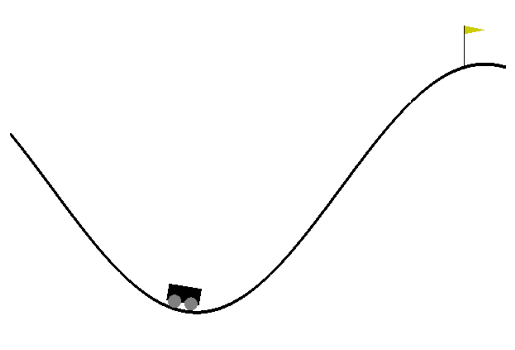

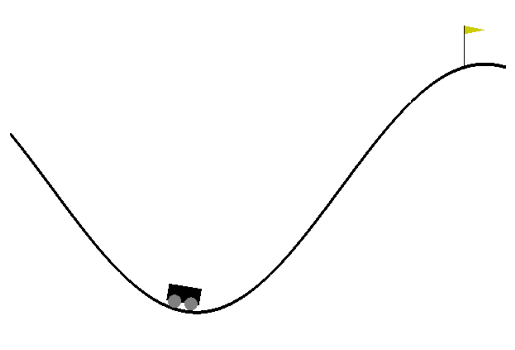

In [9]:
test_env_f = make_vec_env(env_id,
                        wrapper_class=wrapper,
                        n_envs=1)

expert = PPO.load("./logs/ppo_MountainCar_expert.zip", print_system_info=True)

obs = test_env_f.reset()

for _ in range(1000):
    action, _states = expert.predict(obs)
    obs, rewards, dones, info = test_env_f.step(action)
    test_env_f.render(mode="rgb_array")

    if dones:
        break

test_env_f.close()

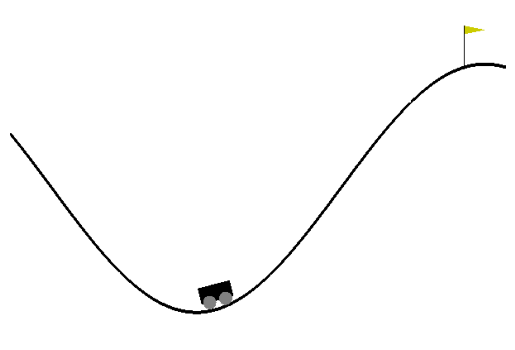

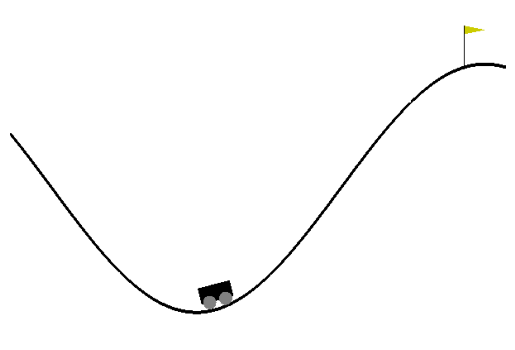

In [12]:
test_env = make_vec_env(env_id,
                        wrapper_class=gnwrapper.Animation,
                        n_envs=1)

noob = PPO.load("./logs/ppo_MountainCar_noob.zip", print_system_info=True)

obs = test_env.reset()

for _ in range(1000):
    action, _states = noob.predict(obs)
    obs, rewards, dones, info = test_env.step(action)
    test_env.render(mode="rgb_array")

    if dones:
        break

test_env.close()

# Imitation Learning
In this section used Behavioral Cloning (BC)

In [13]:
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
import dataclasses
NUM_EPISODES = 100
# expert = PPO.load("./logs/ppo_MountainCar_expert.zip")

env = gym.make(env_id)
env = RolloutInfoWrapper(env) # Wrapper to save origin obs
env = MountainCarContinuousObsWrapper(env) # Wrapper to add angle to obs
env = DummyVecEnv([lambda: env]) # Vectorized env

rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    env,
    rollout.make_sample_until(min_timesteps=None, min_episodes=NUM_EPISODES),
    rng=rng,
    unwrap=True,
)

transitions = rollout.flatten_trajectories(rollouts)
env.close()

/home/vlad1slav/Diploma/rl-venv/lib/python3.10/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [14]:
print(
    f"""The `rollout` function generated a list of {len(rollouts)} {type(rollouts[0])}.
After flattening, this list is turned into a {type(transitions)} object containing {len(transitions)} transitions.
The transitions object contains arrays for: {', '.join(transitions.__dict__.keys())}."
"""
)

The `rollout` function generated a list of 100 <class 'imitation.data.types.TrajectoryWithRew'>.
After flattening, this list is turned into a <class 'imitation.data.types.Transitions'> object containing 12181 transitions.
The transitions object contains arrays for: obs, acts, infos, next_obs, dones."



In [15]:
from imitation.algorithms import bc
from stable_baselines3.common.policies import ActorCriticPolicy

env = gym.make(env_id)
env = gnwrapper.Animation(env)
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    rng=rng,
    policy=ActorCriticPolicy(observation_space=env.observation_space,
                             action_space=env.action_space,
                             lr_schedule=lambda _: torch.finfo(torch.float32).max,
                             net_arch=[64, 64]
                             )
)

In [16]:
bc_trainer.train(n_epochs=2)

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00142 |
|    entropy        | 1.42     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 66.5     |
|    loss           | 1.4      |
|    neglogp        | 1.4      |
|    prob_true_act  | 0.248    |
|    samples_so_far | 32       |
--------------------------------


375batch [00:01, 238.06batch/s]
498batch [00:02, 223.78batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -0.001   |
|    entropy        | 1        |
|    epoch          | 1        |
|    l2_loss        | 0        |
|    l2_norm        | 94.7     |
|    loss           | 0.941    |
|    neglogp        | 0.942    |
|    prob_true_act  | 0.456    |
|    samples_so_far | 16032    |
--------------------------------


755batch [00:03, 249.93batch/s]
760batch [00:03, 231.52batch/s]


# Policy Comparison

In [17]:
from stable_baselines3.common.evaluation import evaluate_policy

In [18]:
expert = PPO.load("./logs/ppo_MountainCar_expert.zip")
noob = PPO.load("./logs/ppo_MountainCar_noob.zip")

In [19]:
test_env_f = make_vec_env(env_id, wrapper_class=wrapper, n_envs=1)
test_env = make_vec_env(env_id, n_envs=1)

expert_reward, expert_reward_std = evaluate_policy(expert, test_env_f, 100)
bc_reward, bc_reward_std = evaluate_policy(bc_trainer.policy, test_env, 100)
noob_reward, noob_reward_std = evaluate_policy(noob, test_env, 100)
print(f'expert reward {expert_reward} +/- {expert_reward_std}')
print(f'BC reward {bc_reward} +/- {bc_reward_std}')
print(f'noob reward {noob_reward} +/- {noob_reward_std}')

expert reward 88.32603394 +/- 2.5599224716309785
BC reward 88.98148456999999 +/- 2.8211702170479085
noob reward 88.56093507999998 +/- 3.310453799519555


## Compare policy architecture

In [21]:
expert.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=1, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

In [22]:
noob.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=1, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

In [23]:
bc_trainer.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (policy_net): Sequential()
    (value_net): Sequential()
  )
  (action_net): Linear(in_features=64, out_features=1, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)